# UMAP 

### Installing and loading libraries

In [2]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


import umap
from scipy.stats import zscore
from sklearn.neighbors import NearestNeighbors
from pathlib import Path

In [1]:
import os
import pandas as pd
import sys
import re
import json
#os.system('pip install "librosa==0.7.1"')
#import librosa
import librosa.display
import numpy as np
import statistics
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install pathlib2') # need to install
import pathlib2
import psutil
import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
#os.system('pip install umap')
#import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gmean
import scipy.stats as stats

### Setting constants

Setting project, input and output folders.

In [12]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")
DF_FULL = os.path.join(os.path.sep, DATA, "df_denoised")
DF_RED = os.path.join(os.path.sep, DATA, "df_denoised_balanced")

### Functions

In [3]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
    padding = maxlen - spec.shape[1]
    z = np.zeros((spec.shape[0],padding))
    padded_spec=np.append(spec, z, axis=1)
    return padded_spec

# UMAP projection

### Preparation

Choose dataset

In [15]:
df = pd.read_pickle(DF_FULL) # full
dftype='full'

#df = pd.read_pickle(DF_RED)  # balanced
#dftype='balanced'

# Remove non-focal calls
df = df[df.nonfocal_yn == 'n']
df.shape

(20064, 34)

In [14]:
df.head(3)

Name        Start  Duration Time Format Type Description call_yn  \
1598  ALARM  1:10:56.215  0:00.178     decimal  Cue         NaN       y   
1599  ALARM  1:12:04.643  0:00.317     decimal  Cue         NaN       y   
1600  ALARM  1:12:15.132  0:00.192     decimal  Cue         NaN       y   

       start_s  duration_s    stop_s  ...  \
1598  4256.215       0.178  4256.393  ...   
1599  4324.643       0.317  4324.960  ...   
1600  4335.132       0.192  4335.324  ...   

                             stretched_mfcc_deltadeltas  \
1598  [[-4.471219, -4.471219, -4.471219, -4.471219, ...   
1599  [[-5.0388603, -5.0388603, -5.0388603, -5.03886...   
1600  [[-4.272333, -4.272333, -4.272333, -4.272333, ...   

                                  denoised_spectrograms  \
1598  [[25.639555, 26.477575, 27.715773, 28.758339, ...   
1599  [[10.762169, 11.25013, 11.792789, 12.15715, 16...   
1600  [[24.188335, 22.856678, 18.059265, 18.200275, ...   

                        denoised_stretched_spectrograms  \
1598  [[42.728127, 36.027912, 21.339691, 33.3617, 33...   
1599  [[31.449883, 24.311474, 19.03553, 20.888477, 1...   
1600  [[34.815525, 32.16957, 28.692219, 25.785461, 2...   

                                         denoised_mfccs  \
1598  [[16.28734, 12.311697, 8.946664, 6.3528423, 1....   
1599  [[-1.2900445, -1.9665908, 2.6229572, 0.0544083...   
1600  [[11.280135, 13.388241, 0.17019328, 4.531397, ...   

                               denoised_stretched_mfccs  \
1598  [[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...   
1599  [[21.421076, 10.742476, -1.0906525, 3.2950172,...   
1600  [[7.3854628, 1.116233, 0.22352138, 0.7825685, ...   

                                   denoised_mfcc_deltas  \
1598  [[-0.61669123, -0.61669123, -0.61669123, -0.61...   
1599  [[0.75837135, 0.75837135, 0.75837135, 0.758371...   
1600  [[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...   

                         denoised_stretched_mfcc_deltas certain_yn index_id  \
1598  [[-1.8924303, -1.8924303, -1.8924303, -1.89243...          y     1598   
1599  [[-2.5341513, -2.5341513, -2.5341513, -2.53415...          y     1599   
1600  [[-0.8115787, -0.8115787, -0.8115787, -0.81157...          y     1600   

     nonfocal_yn  
1598           n  
1599           n  
1600           n  

[3 rows x 35 columns]

Set spec_df to desired dataset

In [ ]:
spec_df = df

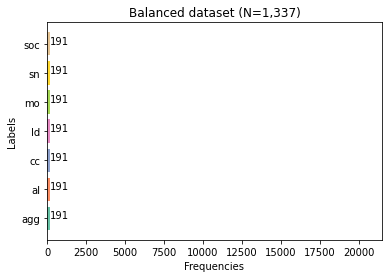

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Balanced dataset (N=1,337)')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,21500)
#plt.show()
plt.savefig(FIGURES+'final/'+'balanced_final.png')

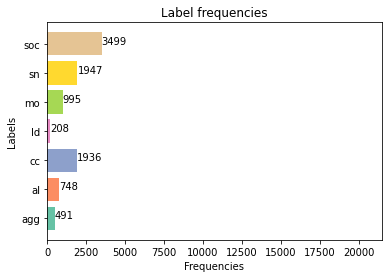

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,21500)
#plt.show()
plt.savefig(FIGURES+'final/'+'balanced_focal.png')

In [ ]:
# D) Balanced classes
wo_cc_df = spec_df[spec_df.call_lable != 'cc']
cc_df = spec_df[spec_df.call_lable == 'cc']
cc_subset = cc_df.sample(frac=0.1, replace=False, random_state=1)
spec_df = pd.concat((wo_cc_df, cc_subset), ignore_index=False, axis=0)

dftype=dftype+'_balanced'

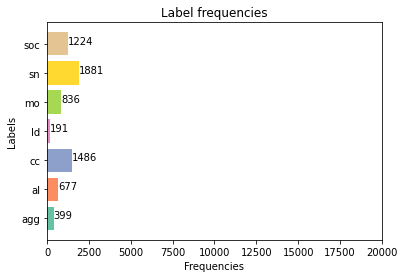

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,20000)

plt.show()

Completely balanced

In [ ]:
# E) Completely balanced classes
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
class_size = np.min(labelcounts.call_lable.values)

subsets = []
for label, num in zip(labelcounts.index, labelcounts.call_lable.values):
  print(label, ":", num, ":", class_size/num)
  subsets.append(spec_df[spec_df.call_lable == label].sample(frac=(class_size/num), replace=False, random_state=1))

spec_df = pd.concat(subsets, axis=0)
dftype = 'complete_balanced'
#pd.DataFrame(spec_df['call_lable'].value_counts())

sn : 1881 : 0.10154173312068049
cc : 1479 : 0.12914131169709264
soc : 1224 : 0.15604575163398693
mo : 836 : 0.2284688995215311
al : 677 : 0.2821270310192024
agg : 399 : 0.47869674185463656
ld : 191 : 1.0


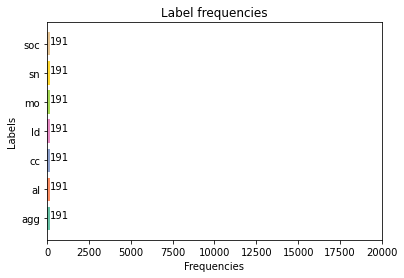

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,20000)

plt.show()

## Divide certain and uncertain

In [ ]:
os.listdir(DATA)

In [ ]:
certain_df = spec_df[spec_df.certain_yn == 'y']
uncertain_df = spec_df[spec_df.certain_yn == 'n']

In [ ]:
certain_df.shape

(5653, 24)

In [ ]:
uncertain_df.shape

(130, 24)

In [ ]:
df.columns

Index(['Name', 'Start', 'Duration', 'Time Format', 'Type', 'Description',
       'call_yn', 'start_s', 'duration_s', 'stop_s', 'date', 'samplerate_hz',
       'indv', 'original_wav', 'bout_number', 'call_lable', 'raw_audio',
       'spectrograms', 'mfccs', 'mfcc_deltas', 'mfcc_deltadeltas',
       'soundfoc_yn', 'stretched_spectrograms', 'stretched_mfccs',
       'stretched_mfcc_deltas', 'stretched_mfcc_deltadeltas',
       'denoised_spectrograms', 'denoised_stretched_spectrograms',
       'denoised_mfccs', 'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas'],
      dtype='object')

## Redo stretched - only once here

In [ ]:
# Spectrogramming paramters

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients
#SR = 48000
#SR = 22050 # for padded
FMAX = 4000
MAX_DURATION = 0.5

In [ ]:
def generate_stretched_mel_spectrogram_NEW(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = duration/MAX_DURATION
    #stretch_rate = 1

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    #D = np.abs(D)**2
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    D_stretched = np.abs(D_stretched)**2

    spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
    s = librosa.power_to_db(spectro, ref=np.max) # power to db transform

    return s

In [ ]:


spectrograms = df.apply(lambda row: generate_stretched_mel_spectrogram_NEW(row['raw_audio'],
                                                                            row['samplerate_hz'], 
                                                                            row['duration_s'],
                                                                            N_MELS,
                                                                            WINDOW,
                                                                            FFT_WIN,
                                                                            FFT_HOP),
                        axis=1)

df['stretched_new'] = spectrograms
df['stretched_denoised_new'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['stretched_new']]

In [ ]:
specs = df.stretched_denoised_new.values

## Choose features

Set specs to desired data and declare method with String. We can use melspectrograms (A) or MFCCs (B). 

In [ ]:
spec_df.columns

Index(['duration_s', 'samplerate_hz', 'indv', 'original_wav', 'bout_number',
       'call_lable', 'raw_audio', 'spectrograms', 'mfccs', 'mfcc_deltas',
       'mfcc_deltadeltas', 'soundfoc_yn', 'stretched_spectrograms',
       'stretched_mfccs', 'stretched_mfcc_deltas',
       'stretched_mfcc_deltadeltas', 'denoised_spectrograms',
       'denoised_stretched_spectrograms', 'denoised_mfccs',
       'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas'],
      dtype='object')

In [ ]:
# 0.1) Using raw audio
specs = spec_df.raw_audio.values # now 2D arrays n_mels+time_frames(varying)
method = 'raw_audio'

maxlen= np.max([spec.shape[0] for spec in specs])
padded_specs = [np.pad(spec, (0,maxlen-spec.shape[0]), 'constant') for spec in specs]
specs_arr = np.asarray(padded_specs)
ztrans = "no_z"
# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(specs_arr))
#ztrans = "z_trans"

In [ ]:
# A.1) Using mel spectrograms:
specs = spec_df.spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'melspectro'

In [ ]:
# A.2) Using stretched mel spectrograms:
specs = spec_df.stretched_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'stretched_melspectro'

In [6]:
# A.3) Using denoised stretched mel spectrograms:
specs = spec_df.denoised_stretched_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_stretched_melspectro'

In [ ]:
# A.3) Using denoised mel spectrograms:
specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'

In [ ]:
lengths = []

for spec in specs:
  lengths.append(spec.shape[1])

np.mean(np.asarray(lengths))

40.23762524300882

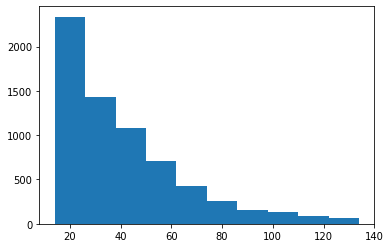

In [ ]:
n, bins, patches = plt.hist(lengths)

In [ ]:
# B.1) Using MFCCs:
specs = spec_df.mfccs.values
method='mfcc'

In [ ]:
# B.2) Using stretched MFCCs:
specs = spec_df.stretched_mfccs.values
method='stretched_mfcc'

In [ ]:
# B.3) Using stretched denoised MFCCs:
specs = spec_df.denoised_stretched_mfccs.values
method='denoised_stretched_mfcc'

In [ ]:
# B.4) Using denoised MFCCs:
specs = spec_df.denoised_mfccs.values
method='denoised_mfcc'

In [ ]:
data.shape

Pad with zeros and normalize

In [7]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))
#data = StandardScaler().fit_transform(pd.DataFrame(data).transpose())
#data = np.asarray(data.transpose())

In [8]:
data.shape

(6687, 5680)

**Optional: Include deltas in feature vector**

Can choose deltas or delta-deltas

In [ ]:
# B.3) Using stretched denoised MFCCs:
deltas = spec_df.denoised_stretched_mfccs.values
method=method+'_mfcc'

In [ ]:
# A.1) MFCC Deltas
deltas = spec_df.mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.2) MFCC Deltas stretched
deltas = spec_df.stretched_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.3) MFCC Deltas stretched denoised
deltas = spec_df.denoised_stretched_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.4) MFCC Deltas denoised
deltas = spec_df.denoised_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# B.1) MFCC Deltadeltas
deltas = spec_df.mfcc_deltadeltas.values
method =method+'_deltadelta'

Or duration

In [ ]:
from scipy.stats import zscore

In [ ]:
dur = zscore(spec_df.duration_s.values)
data = pd.DataFrame(data)
data['dur'] = dur
data = np.asarray(data)

Pad and normalize

In [ ]:
maxlen= np.max([delta.shape[1] for delta in deltas])
flattened_deltas = [pad_spectro(delta, maxlen).flatten() for delta in deltas]
deltas_arr = np.asarray(flattened_deltas)

delta_data = StandardScaler().fit_transform(pd.DataFrame(deltas_arr))
#delta_data = pd.DataFrame(deltas_arr)

Concatenate:

In [ ]:
data = np.concatenate((data, delta_data), axis=1)

## UMAP with custom distance function

In [ ]:
# transform specs

In [ ]:
import numba
from numba import jit

MEL_BINS_REMOVED_LOWER = 5
MEL_BINS_REMOVED_UPPER = 5
N_MELS = 40

@jit(nopython=True)
def calc_zscore(spec):
    mn = np.mean(spec)
    std = np.std(spec)
    for i in range(spec.shape[0]):
        for j in range(spec.shape[1]):
            spec[i,j] = (spec[i,j]-mn)/std
    return spec

@jit(nopython=True)
def preprocess_spec_numba(spec):
    
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec > 3, 3, spec)
    spec = np.where(spec < 0, 0, spec)
    
    return spec

In [ ]:
def pad_transform_spectro(spec,maxlen):

  flat_spec = spec.flatten()
  flat_spec.shape
  spec_l = flat_spec.shape[0]
  trans_spec = np.concatenate((np.asarray([spec_l]), flat_spec, np.asarray([999]*(maxlen-spec_l-1))))
  trans_spec = np.float64(trans_spec)

  return trans_spec

In [ ]:
specs = [preprocess_spec_numba(s) for s in spec_df.spectrograms]
SPEC_SIZE = specs[100].shape[0]

In [ ]:
specs = spec_df.denoised_spectrograms
SPEC_SIZE=specs[100].shape[0]
print(SPEC_SIZE)

40


In [ ]:
maxlen= np.max([spec.shape[1] for spec in specs]) * SPEC_SIZE +1
trans_specs = [pad_transform_spectro(spec, maxlen) for spec in specs]
specs_arr = np.asarray(trans_specs)
data = specs_arr

In [ ]:
data.shape

(6687, 5361)

In [ ]:
@numba.njit()
#@jit(nopython=True)
def pairwise_pad_dist(a, b):

    # len is encoded in first cell
    len_a = int(a[0])
    len_b = int(b[0])

    # reshape specs
    spec_a= np.reshape(a[1:len_a+1], (SPEC_SIZE, -1))
    spec_b= np.reshape(b[1:len_b+1], (SPEC_SIZE, -1))
    
    len_a = spec_a.shape[1]
    len_b = spec_b.shape[1]

    # find bigger spec
    spec_s = spec_a
    spec_l = spec_b
    n_padding = int(len_b - len_a)

    if len_a>len_b:
      spec_s = spec_b
      spec_l = spec_a
      n_padding = int(len_a - len_b)
    
    # pad the smaller spec (if necessary)
    if n_padding!=0:
      pad = np.full((SPEC_SIZE, n_padding), 0.0)
      spec_s_padded = np.concatenate((spec_s, pad), axis=1)
      spec_s_padded = spec_s_padded.astype(np.float64)
    else:
      spec_s_padded = spec_s.astype(np.float64)

    # compute distance

    spec_s_padded = np.reshape(spec_s_padded, (-1))
    spec_l = np.reshape(spec_l, (-1))
    size = spec_l.shape[0]
    spec_l = spec_l.astype(np.float64)

    #dist = (np.sum(np.subtract(spec_s_padded, spec_l)*np.subtract(spec_s_padded, spec_l))) / size
    #dist = np.sqrt((np.sum(np.subtract(spec_s_padded, spec_l)*np.subtract(spec_s_padded, spec_l))) / size)
    dist = (np.sum(np.abs(np.subtract(spec_s_padded, spec_l)))) / size

    return dist

In [ ]:
@numba.njit()
#@jit(nopython=True)
def custom_euclid(a, b):
 
    #dist = (np.sum(np.subtract(a, b)*np.subtract(a, b)))/(a.shape[0])
    dist = (np.sum(np.abs(np.subtract(a, b)))) /(a.shape[0])

    return dist

In [ ]:
res = pairwise_pad_dist(trans_specs[10], trans_specs[20])

In [10]:
os.system('pip install umap-learn')
import umap.umap_ as umap

In [ ]:
reducer = umap.UMAP(low_memory=True,min_dist=0, n_components = 5, metric=pairwise_pad_dist, random_state=2204)
#embedding = reducer.fit_transform(data) 

In [ ]:
embedding = reducer.fit_transform(data) 

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1728: UserWarning:

custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])



## UMAP with precomputed distance matrix

### Simple but with pairwise padding

In [ ]:
import scipy

In [ ]:
# Simple
s_list = list(spec_df.denoised_spectrograms)

distmat = np.zeros((len(s_list), len(s_list)))
for i in range(len(s_list)):
  for j in range(i+1,len(s_list)):
    specs = [s_list[i], s_list[j]]
    spec_ls = [s.shape[1] for s in specs]
    longer = np.argmax(spec_ls)
    maxlen = np.max(spec_ls)

    longer_spec = specs[longer]
    shorter_spec = specs[int(not longer)]

    padded_spec = pad_spectro(shorter_spec, maxlen)
    distmat[i,j] = scipy.spatial.distance.euclidean(padded_spec.flatten(), longer_spec.flatten())

### Preprocessing and pairwise padding

In [ ]:
import numba
from numba import jit

MEL_BINS_REMOVED_LOWER = 5
MEL_BINS_REMOVED_UPPER = 5

@jit(nopython=True)
def calc_zscore(spec):
    mn = np.mean(spec)
    std = np.std(spec)
    for i in range(spec.shape[0]):
        for j in range(spec.shape[1]):
            spec[i,j] = (spec[i,j]-mn)/std
    return spec

@jit(nopython=True)
def preprocess_spec_numba(spec):
    
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec > 3, 3, spec)
    spec = np.where(spec < 0, 0, spec)
    
    return spec

In [ ]:
#s_list = [preprocess_spec_numba(s) for s in spec_df.denoised_spectrograms]
s_list = [preprocess_spec_numba(s) for s in spec_df.spectrograms]

distmat = np.zeros((len(s_list), len(s_list)))
for i in range(len(s_list)):
  for j in range(i+1,len(s_list)):
    specs = [s_list[i], s_list[j]]
    spec_ls = [s.shape[1] for s in specs]
    longer = np.argmax(spec_ls)
    maxlen = np.max(spec_ls)

    longer_spec = specs[longer]
    shorter_spec = specs[int(not longer)]

    padded_spec = pad_spectro(shorter_spec, maxlen)
    distmat[i,j] = scipy.spatial.distance.euclidean(padded_spec.flatten(), longer_spec.flatten())

### With preprocessing and custom min_dist (time-shift)

In [ ]:
from scipy import stats
import random
import numba
from numba import jit
import math

In [ ]:
MIN_OVERLAP = 0.9 # short spectrogram has to have at least MIN_OVERLAP with longer spectrogram
MAX_F_SHIFT = 0 # max frequency shift allowed when comparing spectrograms (in mel bins)
N_MELS=40
N_RANDOM_SHUFFLE = 10
CLIP_VAL = 0 # in denoised_spectrograms, set all values below clip_val to zero
MEL_BINS_REMOVED_LOWER = 5 # remove lowest x=MEL_BINS_REMOVED mel bins from spectrograms
MEL_BINS_REMOVED_UPPER = 5 # remove lowest x=MEL_BINS_REMOVED mel bins from spectrograms

In [ ]:
@jit(nopython=True)
def calc_zscore(spec):
    mn = np.mean(spec)
    std = np.std(spec)
    for i in range(spec.shape[0]):
        for j in range(spec.shape[1]):
            spec[i,j] = (spec[i,j]-mn)/std
    return spec

@jit(nopython=True)
def spec_dist_numba(s_1, s_2):   
    dist = np.sum((np.subtract(s_1, s_2)*np.subtract(s_1, s_2)))  
    # Normalize to random shuffling
    random_dist = calc_random_dist_numba(s_1,s_2)
    norm_dist = dist / random_dist   
    return norm_dist

# Raven cross corrlation
#@jit(nopython=True)
#def spec_dist_numba(s_1, s_2):   
#    numerator = np.sum(s_1*s_2)
#    denominator = math.sqrt(np.sum(s_1**2)*np.sum(s_2**2))
#    dist = numerator/denominator
#    return dist

@jit(nopython=True)
def calc_random_dist_numba(s_1, s_2):
    dists = np.full((N_RANDOM_SHUFFLE),3.)
    s_1_shuffled = np.copy(s_1)
    for i in range(N_RANDOM_SHUFFLE):
        np.random.shuffle(s_1_shuffled)
        dists[i] = np.sum(np.subtract(s_1_shuffled, s_2)*np.subtract(s_1_shuffled, s_2)) 
    return(np.mean(dists))   

@jit(nopython=True)
def calc_mindist_numba(spec_a, spec_b):
    
    # Find the bigger spec   
    if spec_a.shape[1]==spec_b.shape[1]:
        spec_s = spec_a
        len_s = spec_s.shape[1]
        spec_l = spec_b
        len_l = len_s
    else:
        spec_arr = (spec_a, spec_b)
        spec_lens = np.asarray((spec_a.shape[1], spec_b.shape[1]))
        spec_s = spec_arr[np.argmin(spec_lens)] # shorter spec
        len_s = np.min(spec_lens)
        spec_l = spec_arr[np.argmax(spec_lens)] # longer spec
        len_l = np.max(spec_lens)

    # define start position
    min_overlap_frames = int(MIN_OVERLAP * len_s)
    start_timeline = min_overlap_frames-len_s
    max_timeline = len_l - min_overlap_frames
    
    n_of_calculations = (max_timeline+1-start_timeline)+(max_timeline+1-start_timeline)*2*MAX_F_SHIFT

    distances = np.full((n_of_calculations),3.)
    all_start_col_s = np.full((n_of_calculations),3.)
    all_end_col_s = np.full((n_of_calculations),3.)
    all_start_col_l = np.full((n_of_calculations),3.)
    all_end_col_l = np.full((n_of_calculations),3.)

    count=0
    
    for timeline_p in range(start_timeline, max_timeline+1):
        # mismatch on left side
        if timeline_p < 0:
            start_col_l = 0
            len_overlap = len_s - abs(timeline_p)

            end_col_l = start_col_l + len_overlap

            end_col_s = len_s # until the end
            start_col_s = end_col_s - len_overlap

        # mismatch on right side
        elif timeline_p > (len_l-len_s):
            start_col_l = timeline_p
            len_overlap = len_l - timeline_p
            end_col_l = len_l

            start_col_s = 0
            end_col_s = start_col_s + len_overlap

        # no mismatch on either side
        else:
            start_col_l = timeline_p
            len_overlap = len_s
            end_col_l = start_col_l + len_overlap

            start_col_s = 0
            end_col_s = len_s # until the end

        s_s = spec_s[:,start_col_s:end_col_s] 
        s_l = spec_l[:,start_col_l:end_col_l] 
        
        #distances[count] = spec_dist_numba(s_s, s_l)

        distances[count] = np.sum((np.subtract(s_s, s_l)*np.subtract(s_s, s_l))) 
        all_start_col_s[count] = start_col_s
        all_end_col_s[count] = end_col_s
        all_start_col_l[count] = start_col_l
        all_end_col_l[count] = end_col_l
        count = count + 1
        

    #min_dist = np.min(distances)
    
    ind = np.argmin(distances)
    min_dist = distances[ind]
    best_spec_s = spec_s[:,all_start_col_s[ind]:all_end_col_s[ind]]
    best_spec_l = spec_l[:,all_start_col_l[ind]:all_end_col_l[ind]]

    random_dist = calc_random_dist_numba(best_spec_s,best_spec_l)
    norm_dist = min_dist / random_dist 
    
    return norm_dist

@jit(nopython=True)
def preprocess_spec_numba(spec):
    
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec > 3, 3, spec)
    spec = np.where(spec < 0, 0, spec)
    
    return spec

In [ ]:
spec_df.shape

(1337, 35)

In [ ]:
# only preprocess
s_list = [preprocess_spec_numba(s) for s in spec_df.denoised_spectrograms]
maxlen= np.max([spec.shape[1] for spec in s_list])

flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in s_list]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr
data.shape

(6687, 4020)

In [ ]:
x=500
rando_df = spec_df.sample(n=x)

In [ ]:
s_list = [preprocess_spec_numba(s) for s in spec_df.denoised_spectrograms]
#s_list = [preprocess_spec_numba(s) for s in rando_df.denoised_spectrograms]

import timeit

starttime = timeit.default_timer()
print("The start time is :",starttime)

distmat = np.zeros((len(s_list), len(s_list)))
for i in range(len(s_list)):
  for j in range(i+1,len(s_list)):
    s1 = s_list[i]
    s2 = s_list[j]
    min_len = np.min([s1.shape[1], s2.shape[1]])
    max_len = np.max([s1.shape[1], s2.shape[1]])
    if max_len>=2*min_len:
      distmat[i,j] = 2
    elif max_len>=1.5*min_len:
    #if ((s2.shape[1]<=(0.5*s1.shape[1])) or (s2.shape[1]>=(2*s1.shape[1]))):
      distmat[i,j] = 1+spec_dist_numba(s1[:,:min_len],s2[:,:min_len])
    else:
      distmat[i,j] = calc_mindist_numba(s1, s2)

time_diff = timeit.default_timer() - starttime
print("The time difference is :", time_diff)

np.save(PROJECT_PATH+'distmat_reduced_raven.npy', distmat)
#spec_df.to_pickle(PROJECT_PATH+'df_reduced.pkl')

The start time is : 752.485127482
The time difference is : 1732.5907683479998


In [ ]:
print(time_diff/((len(s_list)*(len(s_list)))/2), " s/computation")
print(((len(s_list)*len(s_list))/2)/time_diff, " computations/s")

7.749315544735259e-05  s/computation
12904.365478824533  computations/s


In [ ]:
n=6687
total_time = (n*n)/2/(((x*x)/2)/time_diff)/60/60
print(total_time, "h")

0.7180314797803777 h


### With classic DTW

In [ ]:
os.system('pip install tslearn')
from tslearn.utils import to_time_series
from tslearn.metrics import dtw as tslearn_dtw
from tslearn.metrics import dtw_path as tslearn_dtw_path

In [ ]:
@jit(nopython=True)
def calc_zscore(spec):
    mn = np.mean(spec)
    std = np.std(spec)
    for i in range(spec.shape[0]):
        for j in range(spec.shape[1]):
            spec[i,j] = (spec[i,j]-mn)/std
    return spec

@jit(nopython=True)
def preprocess_spec_numba(spec):   
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)    
    spec = np.where(spec > 3, 3, spec)   
    spec = np.where(spec < 0, 0, spec) 
    return spec
    
@jit(nopython=True)
def spec_dist_numba(s_1, s_2):   
    dist = np.sum((np.subtract(s_1, s_2)*np.subtract(s_1, s_2)))  
    # Normalize to random shuffling
    random_dist = calc_random_dist_numba(s_1,s_2)
    norm_dist = dist / random_dist   
    return norm_dist

@jit(nopython=True)
def calc_random_dist_numba(s_1, s_2):
    dists = np.full((N_RANDOM_SHUFFLE),3.)
    s_1_shuffled = np.copy(s_1)
    for i in range(N_RANDOM_SHUFFLE):
        np.random.shuffle(s_1_shuffled)
        dists[i] = np.sum(np.subtract(s_1_shuffled, s_2)*np.subtract(s_1_shuffled, s_2)) 
    return(np.mean(dists))  

In [ ]:
# calculate warped target
def warp_spec(mapping, ref_spec, ref, target):
  warp_dict = {}
  for el in mapping:
    if (el[0] in warp_dict.keys()):
      warp_dict[el[0]].append(el[1])
    else:
      warp_dict[el[0]] = [el[1]]

  # Warping
  warped_target_spec = np.zeros((ref_spec.shape))

  for i in range(ref_spec.shape[0]):
    mapped = warp_dict[i]
    if (len(mapped)==1):
      warped_target_spec[i,:] = target[mapped[0],:]
    else:
      frames = np.zeros((len(mapped),ref.shape[1]))
      for j,val in enumerate(mapped):
        frames[j,:] = target[val,:]
        warped_target_spec[i,:] = np.mean(frames, axis=0)
  
  return warped_target_spec

In [ ]:
def calc_warped_dist(s_1, s_2, sc_radius=2):

  # find the bigger spec
  specs = [s_1, s_2]
  spec_ls = [s.shape[1] for s in specs]
  longer = np.argmax(spec_ls)

  longer_spec = specs[longer]
  shorter_spec = specs[int(not longer)]

  # Transform specs to time series
  ref_spec = np.transpose(longer_spec)
  target_spec = np.transpose(shorter_spec)

  ref = to_time_series(ref_spec) 
  target = to_time_series(target_spec)

  # Calculate DTW mapping
  mapping, dist = tslearn_dtw_path(ref, target, global_constraint="sakoe_chiba", sakoe_chiba_radius=sc_radius)

  # Calculate warped target
  warped_target_spec = warp_spec(mapping, ref_spec, ref, target)

  # Calculate distance of warped signal to reference
  warped_dist = spec_dist_numba(ref, warped_target_spec)

  return warped_dist

In [ ]:
s_list = [preprocess_spec_numba(s) for s in spec_df.denoised_spectrograms]

In [ ]:
# Check some examples
s_1 = s_list[0]
s_2 = s_list[1]
print(s_1.shape)
print(s_2.shape)

ref_spec = np.transpose(s_1)
target_spec = np.transpose(s_2)

ref = to_time_series(ref_spec) 
target = to_time_series(target_spec)

mapping, dist = tslearn_dtw_path(ref, target, global_constraint="sakoe_chiba", sakoe_chiba_radius=5)
warped_target_spec = warp_spec(mapping, ref_spec, ref, target)
warped_dist = spec_dist_numba(ref, warped_target_spec)

(30, 48)
(30, 85)


In [ ]:
rando_df = spec_df.sample(n=1000)

In [ ]:
s_list = [preprocess_spec_numba(s) for s in spec_df.denoised_spectrograms]
#s_list = [preprocess_spec_numba(s) for s in rando_df.denoised_spectrograms]

import timeit

starttime = timeit.default_timer()
print("The start time is :",starttime)

distmat = np.zeros((len(s_list), len(s_list)))
penalty_mat = np.zeros((len(s_list), len(s_list)))

for i in range(len(s_list)):
  for j in range(i+1,len(s_list)):
    s1 = s_list[i]
    s2 = s_list[j]
    min_len = np.min([s1.shape[1], s2.shape[1]])
    max_len = np.max([s1.shape[1], s2.shape[1]])
    # For calls that differ greatly in length
      # simply cut them and calc distance
    #if max_len>=2*min_len:
    #  distmat[i,j] = spec_dist_numba(s1[:,:min_len],s2[:,:min_len])
    # For calls that differe moderately in length
      # only do time-shift
    if max_len>=1.5*min_len:
      distmat[i,j] = calc_mindist_numba(s1, s2)
    # For calls that are very similar in length
      # find best warp
    else:
      distmat[i,j] = calc_warped_dist(s_list[i], s_list[j], sc_radius=2)

time_diff = timeit.default_timer() - starttime
print("The time difference is :", time_diff)

#np.save(PROJECT_PATH+'distmat_DTW.npy', distmat)
#np.save(PROJECT_PATH+'distmat_DTW.npy', penalty_mat)
#spec_df.to_pickle(PROJECT_PATH+'df_reduced.pkl')

The start time is : 1201.171593132
The time difference is : 305.22121957800005


In [ ]:
print(time_diff/((len(s_list)*(len(s_list)))/2), " s/computation")
print(((len(s_list)*len(s_list))/2)/time_diff, " computations/s")

0.00035577586227328843  s/computation
2810.758418545697  computations/s


In [ ]:
n=6687
total_time = (n*n)/2/(((len(s_list)*len(s_list))/2)/time_diff)/60/60
print(total_time, "h")

3.4408865298714213 h


In [ ]:
spec_ls

[54, 111]

In [ ]:
shorter_spec.shape

(30, 54)

Ref:  0.258
Target:  0.059000000000000004
DTW:  27.634007919774895
DTW warped:  27.634007919774895


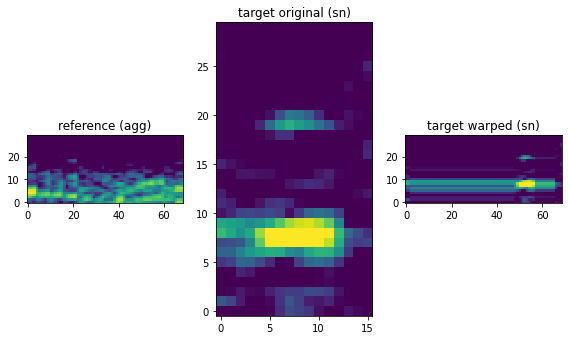

In [ ]:
# Randomly select two spectrograms
ex = spec_df.sample(n = 2, replace=False) 

# of the same group
#calltype = 'ld'
#ex =spec_df[spec_df['call_lable']==calltype].sample(n = 2, replace=False) 

ex_specs = [preprocess_spec_numba(s) for s in ex.denoised_spectrograms]


# find the bigger spec
spec_ls = [s.shape[1] for s in ex_specs]
longer = np.argmax(spec_ls)

longer_spec = ex_specs[longer]
shorter_spec = ex_specs[int(not longer)]


ex_dur = ex.duration_s.values
ex_labels = [list(ex.call_lable.values)[longer], list(ex.call_lable.values)[int (not longer)]]
ex_labels = np.append(ex_labels,list(ex.call_lable.values)[int (not longer)])

# Transform specs to time series
ref_spec = np.transpose(longer_spec)
target_spec = np.transpose(shorter_spec)


print("Ref: ", ex_dur[longer])
print("Target: ", ex_dur[int(not longer)])

# Get DTW path

#ref = to_time_series(np.transpose(stats.zscore(ex_specs[0], axis=None)))  # this would be for normalized spectrogram
#target = to_time_series(np.transpose(stats.zscore(ex_specs[1], axis=None))) # this would be for normalized spectrogram
ref = to_time_series(ref_spec)  # do not normalize spectrogram
target = to_time_series(target_spec) # do not normalize spectrogram

mapping, dist = tslearn_dtw_path(ref, target, global_constraint="sakoe_chiba", sakoe_chiba_radius=3)
warped_target_spec = warp_spec(mapping, ref_spec, ref, target)
warped_dist = spec_dist_numba(ref, warped_target_spec)

print("DTW: ",dist)  

# Distance of warped:
#warped_target = to_time_series(stats.zscore(warped_target_spec, axis=None)) # this would be for normalized spectrogram
warped_target = to_time_series(warped_target_spec) # do not normalize spectrogram
mapping2, dist2 = tslearn_dtw_path(ref, warped_target, global_constraint="sakoe_chiba", sakoe_chiba_radius=3)

print("DTW warped: ", dist2)
aspect_param = 'equal'
plt.figure(figsize=(8,8))
titles = ['reference', 'target original', 'target warped']
for i,spec in enumerate([ref_spec, target_spec, warped_target_spec]):
  plt.subplot(1, 3, i+1)
  #librosa.display.specshow(np.transpose(spec))
  plt.imshow(np.transpose(spec), interpolation='nearest', origin='lower', aspect=aspect_param) 
  title = titles[i]+" ("+ex_labels[i]+")"
  plt.title(title)
plt.tight_layout() 

DTW:  23.213182533268387
DTW warped:  23.213182533268387


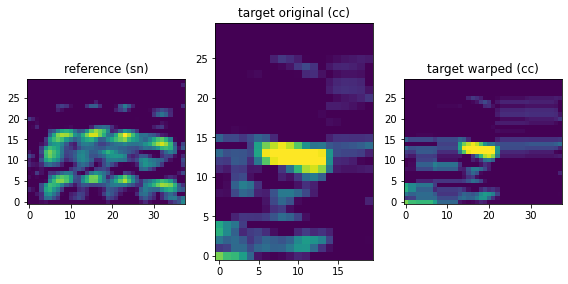

In [ ]:
warped_target_spec = warp_spec(mapping, ref_spec, ref, target)
warped_dist = spec_dist_numba(ref, warped_target_spec)

print("DTW: ",dist)  

# Distance of warped:
#warped_target = to_time_series(stats.zscore(warped_target_spec, axis=None)) # this would be for normalized spectrogram
warped_target = to_time_series(warped_target_spec) # do not normalize spectrogram
mapping2, dist2 = tslearn_dtw_path(ref, warped_target, global_constraint="sakoe_chiba", sakoe_chiba_radius=10)

print("DTW warped: ", dist2)
aspect_param = 'equal'
plt.figure(figsize=(8,8))
titles = ['reference', 'target original', 'target warped']
for i,spec in enumerate([ref_spec, target_spec, warped_target_spec]):
  plt.subplot(1, 3, i+1)
  #librosa.display.specshow(np.transpose(spec))
  plt.imshow(np.transpose(spec), interpolation='nearest', origin='lower', aspect=aspect_param) 
  title = titles[i]+" ("+ex_labels[i]+")"
  plt.title(title)
plt.tight_layout() 

In [ ]:
distmat = np.load(PROJECT_PATH+'custom_distmat.npy')
spec_df=pd.read_pickle(PROJECT_PATH+'custom_df.pkl')

distmat = np.load(PROJECT_PATH+'distmat_3000.npy')
spec_df=pd.read_pickle(PROJECT_PATH+'df_3000.pkl')

s_list = list(spec_df.denoised_spectrograms.values)

In [ ]:
# about 150 comparisons per second

156.25

### Run

In [ ]:
for i in range(len(s_list)):
  for j in range(i+1,len(s_list)):
    distmat[j,i] = distmat[i,j]

In [ ]:
# Some examples

2.0631909370422363


(-0.5, 14.5, -0.5, 39.5)

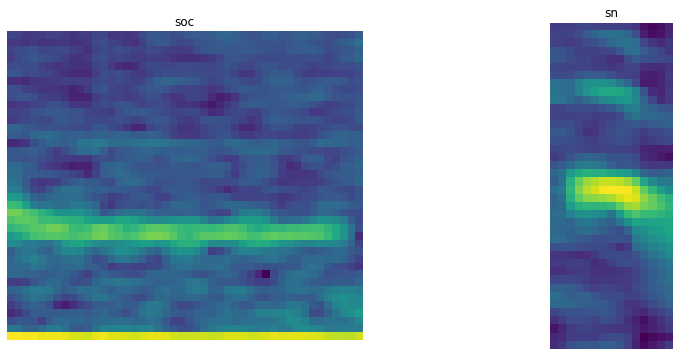

In [ ]:
fig = plt.figure(figsize=(14,6))
labels = small_df.call_lable.values
i=random.randrange(0, 300, 1)
j=random.randrange(0, 300, 1)

print(distmat[i,j])

spec = s_list[i]
plt.subplot(1, 2, 1)
plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
plt.title(labels[i])
plt.axis('off')

spec = s_list[j]
plt.subplot(1, 2, 2)
plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
plt.title(labels[j])
plt.axis('off')

In [ ]:
reducer = umap.UMAP(low_memory=True,n_components = 5, min_dist=0, metric='precomputed')
embedding = reducer.fit_transform(distmat)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



In [ ]:
umap_df = spec_df

In [ ]:
umap_df = rando_df

## Running UMAP

In [ ]:
specs = [preprocess_spec_numba(s) for s in spec_df.spectrograms]

In [ ]:
n_neighbors = 15
n_components

In [ ]:
specs = spec_df.denoised_spectrograms

In [ ]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr
data.shape

(6687, 5360)

In [11]:
reducer = umap.UMAP(low_memory=True,
                    n_components = 5, 
                    min_dist=0,
                    random_state=2204) 

In [ ]:
reducer = umap.UMAP(low_memory=True,
                    #metric = custom_euclid,
                    metric = pairwise_pad_dist,
                    n_components = 5, 
                    min_dist=0,
                    random_state=2204) 

In [12]:
embedding = reducer.fit_transform(data)

### Supervised

In [ ]:
call_labels = np.asarray(pd.factorize(spec_df.call_lable.values))
call_labels = call_labels[0]

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
# Supervised!
call_labels = np.asarray(pd.factorize(spec_df.call_lable.values))
call_labels = call_labels[0]

reducer = umap.UMAP(low_memory=True,n_components = 10, target_weight=0.2)
embedding = reducer.fit_transform(data,y=call_labels) # supervised dim reduction

In [ ]:
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)

In [ ]:
embedding = reducer.fit_transform(data)
embedding.shape # (27244, 2) all

(6687, 5)

### Save embedding



In [ ]:
#method = method+'_focal'
print(method)

denoised_stretched_melspectro


In [ ]:
datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_'+method+'_'+dftype

'2020-10-27_embedding_denoised_melspectro_complete_balanced'

In [ ]:
spec_df.head(3)

Name        Start  ... certain_yn nonfocal_yn
1584   CC  1:00:15.043  ...          y           n
1585   CC  1:00:35.627  ...          y           n
1586   CC  1:01:10.577  ...          y           n

[3 rows x 34 columns]

In [ ]:
embedding = pd.DataFrame(embedding)
embedding['index_id'] = spec_df['index_id']
#embedding['index_id'] = spec_df.index

#embedding_filename = datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_full_focal'
embedding_filename = datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_'+method+'_'+dftype
#embedding_filename = datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_denoised_melspectro_balanced_no_z'
#embedding_filename = '2020-20-26_embedding_denoised_melspectro_focal_10dims'
print(DATA+embedding_filename)
embedding.to_pickle(DATA+embedding_filename)

/content/drive/My Drive/meerkat/data/2020-10-28_embedding_denoised_stretched_melspectro_focal


In [ ]:
os.listdir(DATA)

In [ ]:
# NOT z-Transformed
embedding_filename = '2020-10-27_embedding_full_focal' # 20,0064
#embedding_filename='2020-10-14_embedding_denoised_melspectro_full' # 27,224
#embedding_filename = '2020-10-14_embedding_denoised_melspectro_balanced'# 9,824
#embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal' # 6,687
#embedding_filename = '2020-20-26_embedding_denoised_melspectro_focal_10dims' # 6,687
#embedding_filename = '2020-10-27_embedding_denoised_melspectro_complete_balanced' # 1,337
ztrans = "no_z"

# z-transformed
#embedding_filename = '2020-10-14_embedding_no_z_denoised_melspectro_full' # 27,224 
#embedding_filename = '2020-10-23_embedding_denoised_melspectro_balanced_no_z'# 9,824 # ???
#embedding_filename = '2020-10-20_embedding_denoised_melspectro_focal_focal' # I GUESS # 6,687
#ztrans = "z_trans"

In [ ]:
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = np.asarray(embedding)[:,0:5]

PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(data)
embedding = pca.transform(data)

## Visualization

### 3D Plots

#### Matplotlib animation

In [13]:
#umap_df = rando_df
umap_df = spec_df
#embedding = np.asarray(embedding)

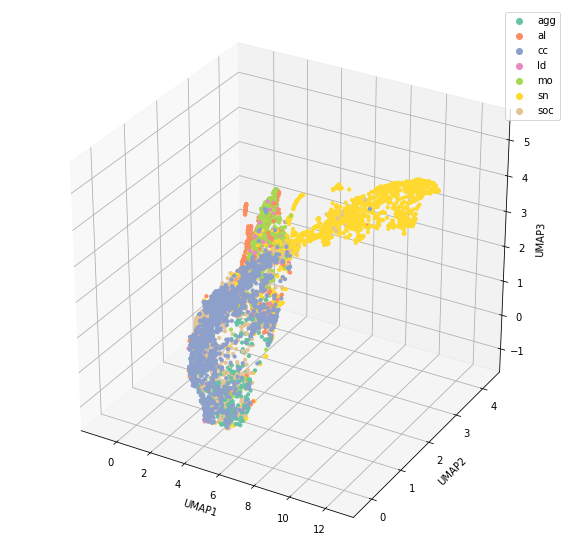

In [14]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = umap_df.call_lable.values
#scat_labels = aggl_clusterer.labels_
#scat_labels = kmeans.labels_
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               #xs = umap_df['UMAP1'],
               #ys = umap_df['UMAP2'],
               zs = embedding[:,2],
               #zs= umap_df.duration_s.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

#ax.set_xlabel('tSNE1')
#ax.set_ylabel('tSNE2')
#ax.set_zlabel('Duration')
ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

plt.show()
#plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+embedding_filename)
#plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_custom_focal.jpg')

Animation:

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'custom_dist_focal'+'.gif', dpi=80, writer='pillow', fps=12)

#anim.save(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_'+method+'_'+dftype+'.gif', dpi=80, writer='pillow', fps=12)
#anim.save(FIGURES+'2020-10-23-melpectro_denoised_UMAP3_not_z.gif', dpi=80, writer='pillow', fps=12)

#anim.save(FIGURES+'melpectro_denoised_UMAP3.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

#### Plotly

In [ ]:
scaler = MinMaxScaler(feature_range=(0,10))
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

In [ ]:
spec_df=df
spec_df.shape
umap_df = spec_df

In [15]:
#t = np.linspace(0, 10, 50)
x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
#x, y, z = embedding_scaled[:,0], embedding_scaled[:,1], embedding_scaled[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]

scat_labels = umap_df.call_lable.values
#scat_labels = umap_df.indv.values
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = umap_df.indv.values+" "+umap_df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

### 2D plots

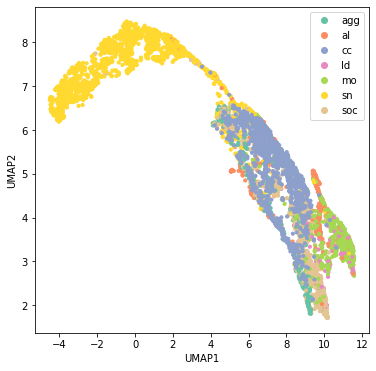

In [ ]:
# 2D plot

fig = plt.figure(figsize=(6,6))
scat_labels = umap_df.call_lable.values
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

plt.scatter(embedding[:,0], embedding[:,1], alpha=1,
            s=10, c=c)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2');

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
plt.legend(scatters, labeltypes, numpoints = 1)
plt.show()

### AVGN Plots

In [ ]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [ ]:
z  = list(embedding[:,0:2])
z = np.vstack(z)

# Use spectrogram examples
#specs = spec_df.spectrograms.values
#specs = spec_df.stretched_spectrograms.values
specs = spec_df.denoised_stretched_spectrograms.values

#### By individual

/content/drive/My Drive/meerkat/figures/2020-09-13_denoised_stretched_melspectro_focal_ind


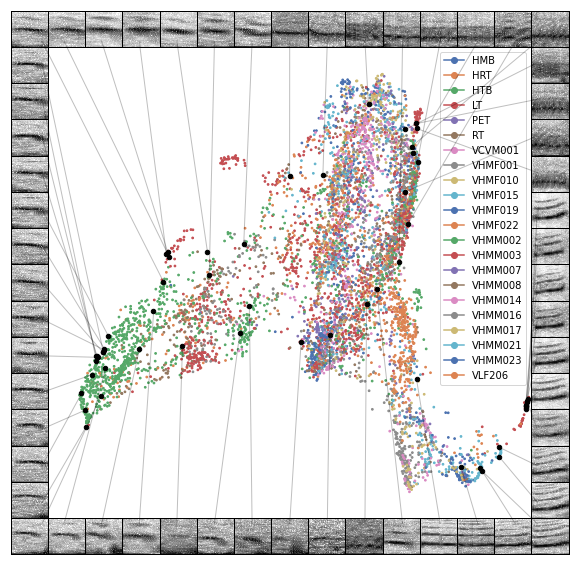

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.indv.values,
        'alpha':1.0,
        's': 3,
        #"color_palette": 'Set2',
        "color_palette": 'deep',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_ind'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By label

/content/drive/My Drive/meerkat/figures/2020-10-272020-10-27_embedding_full_focalAVGN


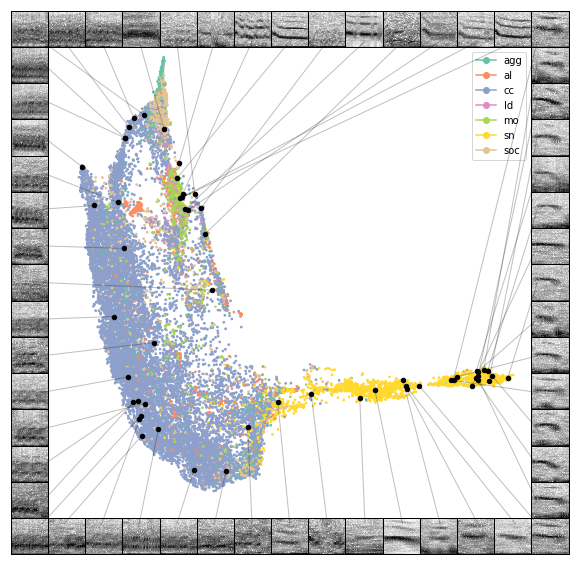

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.call_lable.values,
        #'labels': np.repeat([1], spec_df.shape[0]),
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_call'
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+embedding_filename+'AVGN'
save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By recording type (focal or nonfocal)

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.soundfoc_yn.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_soundfoc'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

# MDS

In [ ]:
from sklearn import manifold

In [ ]:
mds = manifold.MDS(n_components=3, max_iter=100, n_init=1)

In [ ]:
Y = mds.fit_transform(data)

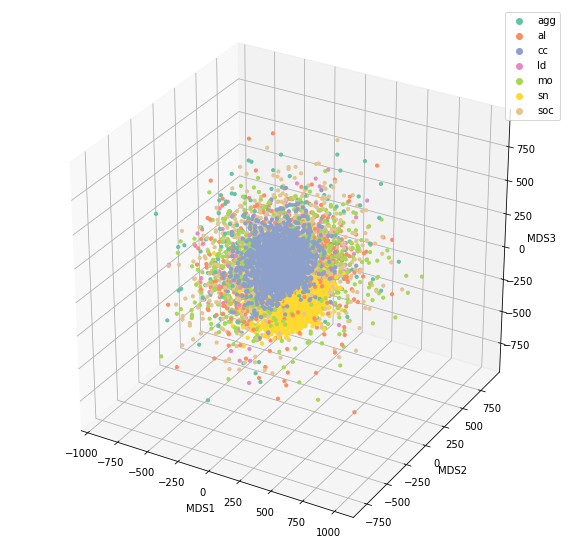

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = spec_df.call_lable.values
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = Y[:,0],
               ys = Y[:,1],
               zs = Y[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
ax.set_zlabel('MDS3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'MDS')

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 10), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'MDS'+'.gif', dpi=80, writer='pillow', fps=12)

In [ ]:
#t = np.linspace(0, 10, 50)
x, y, z = Y[:,0], Y[:,1], Y[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
#x, y, z = embedding_scaled[:,0], embedding_scaled[:,1], embedding_scaled[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]

scat_labels = spec_df.call_lable.values
#scat_labels = umap_df.indv.values
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = spec_df.indv.values+" "+spec_df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# UMAP with random distance matrix

To see how embedding scores 

In [ ]:
random_distmat = np.random.rand(data.shape[0],data.shape[0])

In [ ]:
random_distmat.shape

(9824, 9824)

In [ ]:
for i in range(random_distmat.shape[0]):
  for j in range(i,random_distmat.shape[0]):
      random_distmat[i,j] = random_distmat[j,i]

for i in range(random_distmat.shape[0]):
  random_distmat[i,i] = 0

In [ ]:
reducer = umap.UMAP(low_memory=True, metric='precomputed', min_dist=0, n_components=10)
embedding = reducer.fit_transform(random_distmat)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



# Embedding evaluation

Evaluate the embedding. Since it's unsupervised, this is really difficult. Best would be to have a measure of dissimilarity that we trust but there's no obvious choice. VGG Net similarity would be an option.

Thus, for now, evaluate it based on the labelled calls.

In [ ]:
# Add duration
embedding_df = pd.DataFrame(embedding)
embedding_df['duration'] = umap_df.duration_s.values

embedding = np.asarray(embedding_df)
embedding_df.head(3)

#df = pd.read_pickle(DATA+'embedding_denoised_stretched_mfcc_delta_balanced')
calltypes = sorted(list(set(umap_df['call_lable'])))

#embedding_vars = ['UMAP1', 'UMAP2', 'duration_s'] 
#embedding = np.asarray(df[embedding_vars])
labels = df.call_lable.values

# Normalize
scaler = MinMaxScaler(feature_range=(0,10))
scaler.fit(embedding)
embedding = scaler.transform(embedding)
metric_type = 'euclidean'

In [ ]:
umap_df = spec_df
print(umap_df.shape)
print(embedding.shape)

(6687, 35)
(6687, 5)


In [18]:
umap_df = spec_df
calltypes = sorted(list(set(umap_df['call_lable'])))
labels = umap_df.call_lable.values

## Find nearest neighbors

In [16]:
k=5
n_comps = 5

# Find k nearest neighbors
#nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
#distances, indices = nbrs.kneighbors(embedding)


nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding[:,0:n_comps])
#nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(data)

distances, indices = nbrs.kneighbors(embedding[:,0:n_comps])
#distances, indices = nbrs.kneighbors(data)


# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
# for precomputed
distances = []
indices = []
k=5

for i in range(distmat.shape[0]):
  ind = np.argpartition(distmat[i,:], k)[:k]
  indices.append(ind)

In [19]:
nn_stats_dict = {}

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

  for i,ind in enumerate(call_indices):
    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = labels[neighbor]
      #calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
      calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 0.2 
  nn_stats_dict[calltype] = calltype_counts

In [ ]:
nn_stats_dict['al']

array([[0. , 0. , 0.4, ..., 0. , 0. , 0.6],
       [0. , 0.6, 0. , ..., 0.4, 0. , 0. ],
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.6, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ],
       [0. , 0. , 0.8, ..., 0. , 0. , 0.2]])

## Calculate metrics

In [20]:
# Overall frequencies
overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  sub_emb = embedding[labels==calltype,:]
  overall[i] = sub_emb.shape[0] 
  #overall[i]=191

overall = (overall/np.sum(overall))*100


stats_tab = np.zeros((len(calltypes),len(calltypes)))
stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

for i, calltype in enumerate(calltypes):
  stats = nn_stats_dict[calltype]
  #stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100  
  #stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall
  stats_tab[i,:] = np.mean(stats,axis=0)*100
  stats_tab_norm[i,:] = (np.mean(stats,axis=0)*100)/overall

stats_tab = pd.DataFrame(stats_tab)
stats_tab_norm = pd.DataFrame(stats_tab_norm)

stats_tab.loc[len(stats_tab)] = overall
#stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

stats_tab.columns = calltypes
stats_tab.index = calltypes+['overall']

stats_tab_norm.columns = calltypes
stats_tab_norm.index = calltypes
x = stats_tab_norm.replace(0,0.0001)
stats_tab_norm = np.log2(x)

In [ ]:
stats_tab

agg         al         cc  ...         mo         sn        soc
agg      43.358396   3.408521  10.726817  ...   1.804511   6.315789  33.734336
al        2.245199  65.169867   9.423929  ...  13.116691   3.042836   5.140325
cc        2.731575   3.502366  79.256254  ...   1.852603   2.177147   9.601082
ld        0.732984   7.958115   6.701571  ...  37.172775   1.047120  18.638743
mo        1.004785  10.071770   4.210526  ...  67.272727   1.411483   7.511962
sn        1.573631   1.020734   2.317916  ...   0.648591  91.547049   2.743222
soc      10.816993   3.006536  12.401961  ...   4.444444   3.888889  63.137255
overall   5.966801  10.124121  22.117541  ...  12.501869  28.129206  18.304172

[8 rows x 7 columns]

In [ ]:
stats_tab_norm

agg        al        cc        ld        mo        sn       soc
agg  2.861282 -1.570579 -1.043969 -2.132019 -2.792464 -2.155034  0.882045
al  -1.410114  2.686408 -1.230790 -0.617946  0.069260 -3.208580 -1.832241
cc  -1.127224 -1.531395  1.841334 -1.700252 -2.754518 -3.691558 -0.930904
ld  -3.025104 -0.347298 -1.722620  3.280206  1.572103 -4.747570  0.026132
mo  -2.570071 -0.007479 -2.393119  1.576161  2.427878 -4.316785 -1.284911
sn  -1.922860 -3.310118 -3.254291 -4.262143 -4.268691  1.702445 -2.738229
soc  0.858270 -1.751623 -0.834623 -0.310050 -1.492069 -2.854639  1.786319

In [ ]:
import seaborn as sns

In [21]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.3128883359867296
Log final metric (unweighted) gmean: 2.2470841320093053
Abs final metric (unweighted): 61.17


Text(24.0, 0.5, 'datapoint label')

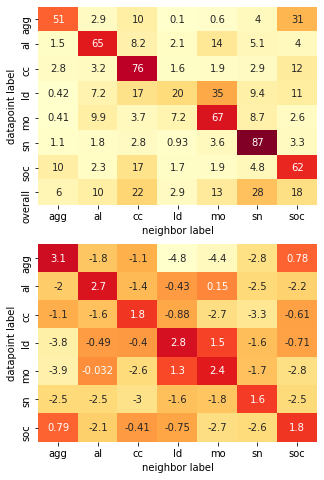

In [22]:
plt.figure(figsize=(5,8))

plt.subplot(2, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)
#plt.subplot(1, 3, 2)
#ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd')
#plt.xlabel("neighbor label")
#plt.ylabel("datapoint label")
#plt.show()

plt.subplot(2, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

#plt.savefig(FIGURES+'2020-10-14_embedding_denoised_melspectro_balanced_eval3D.png')
#plt.savefig(FIGURES+embedding_filename+'_eval'+str(n_comps)+'D.png')
#plt.savefig(FIGURES+'denoised_balanced_focal_original_space_eval.png')
#print(FIGURES+embedding_filename+'_eval3D.png')

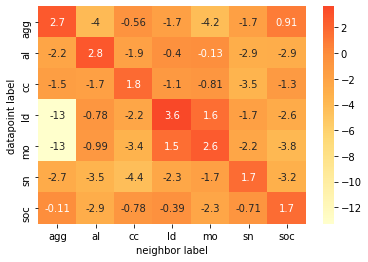

In [ ]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()
# log2(probability of neighbor label within k nearest neighbors of datapoint / overallll probability of neighbor label)

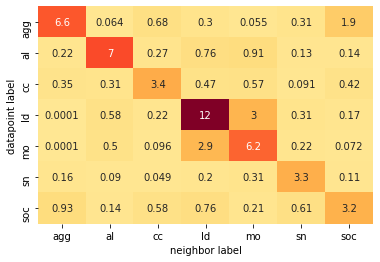

In [ ]:
# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)

ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd',cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

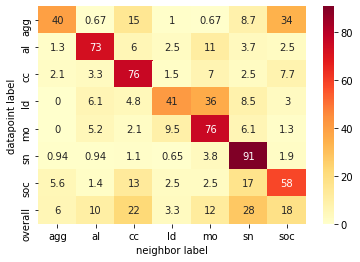

In [ ]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

Calculate percentage of "correct" neighbors. Overlooking the fact that we don't even desire to always have the same calltype in the ten nearest datapoints, but alright.

In [ ]:
np.diagonal(stats_tab.iloc[:-1,])

array([29.57230143, 58.85026738, 53.40392562, 11.68269231, 54.75376884,
       88.88546482, 65.33866819])

## k curve

In [ ]:
metrics_dict = {}

In [ ]:
encoding = 'spectrogram'
method = 'original'

df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']


specs = spec_df.denoised_spectrograms.values
labels = spec_df.call_lable.values


maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr
embedding=data


In [ ]:
# OR FOCAL:
encoding = 'spectrogram'
method = 'embedded'

df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']

labels = spec_df.call_lable.values
embedding = pd.read_pickle(DATA+'2020-10-14_embedding_denoised_melspectro_focal')
embedding = np.asarray(embedding)[:,0:5]


In [ ]:
# OR BALANCED:
encoding = 'spectrogram'
method = 'embedded'

df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df


labels = spec_df.call_lable.values
embedding = pd.read_pickle(DATA+'2020-10-14_embedding_denoised_melspectro_balanced')
embedding = np.asarray(embedding)[:,0:5]

In [ ]:
ks = [1,3,5,8,10,15,20,30,40]

metrics_tab = np.zeros((len(ks),4))
for k_num,k in enumerate(ks):
#k=1

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  nn_stats_dict = {}
  calltypes = sorted(list(set(labels)))
  labels = np.asarray(labels)

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts

  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    sub_emb = embedding[labels==calltype,:]
    overall[i] = sub_emb.shape[0] 

  overall = (overall/np.sum(overall))*100

  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  x=stats_tab_norm.replace(0, 0.0001)
  stats_tab_norm = np.log2(x)

  metrics_tab[k_num,0] = np.mean(np.diagonal(stats_tab_norm))
  metrics_tab[k_num,1] = np.average(np.diagonal(stats_tab_norm), weights=overall)
  metrics_tab[k_num,2] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  metrics_tab[k_num,3] = np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)

metrics_dict[encoding+'_'+method] = metrics_tab

In [ ]:
metrics_dict.keys()

dict_keys(['spectrogram_original', 'spectrogram_embedded'])

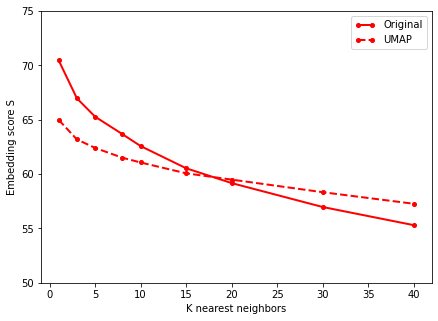

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='red', marker='o', linewidth=2, markersize=4, label="Original")
plt.plot(ks, metrics_dict['spectrogram_embedded'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="UMAP")
plt.ylabel("Embedding score S")
plt.xlabel("K nearest neighbors")
plt.legend(numpoints=2)
plt.ylim(50,75)

plt.savefig(FIGURES+'spectrogram_balanced_focal_ks.png')

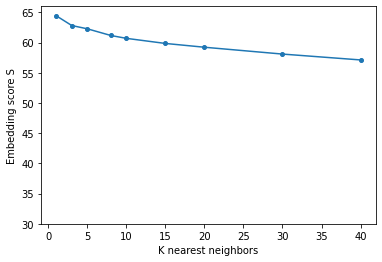

In [ ]:
#fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['spectrogram_embedded'][:,2], marker='o', markersize=4)
plt.ylabel("Embedding score S")
plt.xlabel("K nearest neighbors")
#plt.axvline(x=5, color="black", linestyle='--')
plt.ylim(30,66)
#plt.show()
plt.savefig(FIGURES+'opti_UMAP_ks.png')

## Original vs. spec N=5

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']

specs = spec_df.denoised_spectrograms.values
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
original_embedding =data

In [ ]:
# Make 5 UMAPs

n_times=5
embeddings_dict={}
for i in range(n_times):
  reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0)
  embeddings_dict[i] = reducer.fit_transform(data)
  

In [ ]:
ks = [1,3,5,8,10,15,20,30,40]
ks = [1,3,5,8,10,15,20,30,40,50,100,200]

metrics_tab = np.zeros((len(ks)*n_times,2))

i=0
for embedding in embeddings_dict.values():
  indices, distances = get_knn(np.max(np.asarray(ks)),embedding)
  for k_num,k in enumerate(ks):
    these_indices = [x[0:k] for x in indices]
    #indices, distances = get_knn(k,embedding)
    nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
    stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)
    
    metrics_tab[i,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    metrics_tab[i,1] = np.mean(np.diagonal(stats_tab_norm))
    i+=1


In [ ]:
metrics_tab_df = pd.DataFrame(metrics_tab)
metrics_tab_df['k'] = ks*n_times
metrics_tab_df.columns = ['S', 'Snorm', 'k']

means_df = metrics_tab_df.groupby('k').mean()
stds_df = metrics_tab_df.groupby('k').std()

In [ ]:
metrics_tab_df

In [ ]:
ks = [1,3,5,8,10,15,20,30,40]
ks = [1,3,5,8,10,15,20,30,40,50,100,200]

metrics_tab_f = np.zeros((len(ks),2))

indices, distances = get_knn(np.max(np.asarray(ks)),original_embedding)

for k_num,k in enumerate(ks):
  these_indices = [x[0:k] for x in indices]
  nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
  stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)
    
  metrics_tab_f[k_num,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  metrics_tab_f[k_num,1] = np.mean(np.diagonal(stats_tab_norm))


In [ ]:
metrics_tab_f_df = pd.DataFrame(metrics_tab_f)
metrics_tab_f_df['k'] = ks
metrics_tab_f_df.columns = ['S', 'Snorm', 'k']

In [ ]:
metrics_tab_f_df

S     Snorm    k
0   69.622313  2.554361    1
1   66.131326  2.445700    3
2   64.360409  2.392981    5
3   62.314171  2.333516    8
4   60.995045  2.290927   10
5   59.164837  2.236207   15
6   57.691912  2.185847   20
7   55.556692  2.113660   30
8   53.900385  2.054293   40
9   52.494281  2.000988   50
10  47.661442  1.814866  100
11  41.916876  1.558765  200

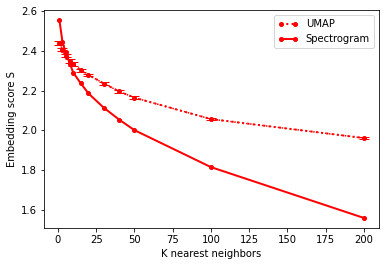

In [ ]:
#fig = plt.figure(figsize= (6, 4))

var ='Snorm'
plt.plot(ks, means_df[var], color = 'red', marker='o', linestyle='dotted', linewidth=2, markersize=4,label='UMAP')
plt.errorbar(ks, means_df[var], yerr=stds_df[var], linestyle='dotted', capsize=5, color = 'red')

plt.plot(ks, metrics_tab_f_df[var], marker='o',linewidth=2, markersize=4, color ='red',label='Spectrogram')


plt.legend(numpoints=2)

plt.ylabel('Embedding score S')
plt.xlabel('K nearest neighbors')

plt.savefig(FIGURES+'2020-10-27_comparison_improved'+var)

# Look at example misclassified calls

In [ ]:
embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal'
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = np.asarray(embedding)[:,0:5]


In [ ]:
spec_df.shape

(6687, 35)

In [ ]:
k=5

# Find k nearest neighbors
#nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
#distances, indices = nbrs.kneighbors(embedding)

nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
labels = spec_df['call_lable'].tolist()

In [ ]:
wrong_neighbors = []
wrong_neighbors_row_num = []
wrong_datapoint = []
wrong_rownum = []

for i in range(spec_df.shape[0]):
  datapoint_label = labels[i]
  neighbors = indices[i]
  neighbor_labels = [labels[x] for x in neighbors]

  if datapoint_label not in neighbor_labels:
    wrong_neighbors.append(neighbor_labels)
    wrong_neighbors_row_num.append(neighbors)
    wrong_datapoint.append(datapoint_label)
    wrong_rownum.append(i)

In [ ]:
len(wrong_neighbors)

590

In [ ]:
wrong_df = pd.DataFrame(list(zip(wrong_rownum, wrong_datapoint)), 
               columns =['row_num', 'call_lable']) 

In [ ]:
wrong_neighbors_arr = np.vstack(wrong_neighbors)

for i in range(wrong_neighbors_arr.shape[1]):
  col_name = "neighbor_"+str(i+1)
  wrong_df[col_name] = wrong_neighbors_arr[:,i]

In [ ]:
wrong_neighbors_row_num_arr = np.vstack(wrong_neighbors_row_num)

for i in range(wrong_neighbors_row_num_arr.shape[1]):
  col_name = "neighbor_"+str(i+1)+"_rownum"
  wrong_df[col_name] = wrong_neighbors_row_num_arr[:,i]

In [ ]:
wrong_df

row_num call_lable  ... neighbor_4_rownum neighbor_5_rownum
0          0         al  ...              5608              5308
1          2         al  ...              5022              4819
2          7        agg  ...               344              1187
3          9        agg  ...              5262              5642
4         14        agg  ...              6654              6611
..       ...        ...  ...               ...               ...
585     6626         cc  ...               909               926
586     6651         cc  ...              4384              1549
587     6656         cc  ...               635              1296
588     6670         cc  ...                55               709
589     6685         cc  ...              2199              1449

[590 rows x 12 columns]

In [ ]:
w = pd.DataFrame(wrong_df['call_lable'].value_counts())
w.sort_index(inplace=True)

a = pd.DataFrame(spec_df['call_lable'].value_counts())
a.sort_index(inplace=True)

In [ ]:
tab = pd.DataFrame({'mispositioned': w['call_lable'], 'overall': a['call_lable'], 'percentage': 100*(w['call_lable']/a['call_lable'])})
tab

mispositioned  overall  percentage
agg             80      399   20.050125
al             103      677   15.214180
cc              67     1479    4.530088
ld              58      191   30.366492
mo              64      836    7.655502
sn              63     1881    3.349282
soc            155     1224   12.663399

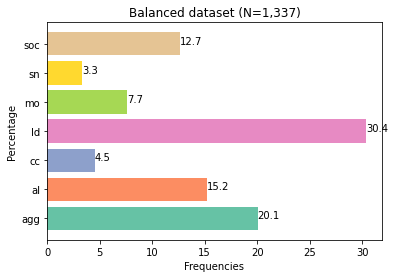

In [ ]:
pal = sns.color_palette("Set2", n_colors=len(tab.index))
plt.barh(tab.index, tab.percentage.values, color = pal)

for index, value in enumerate(tab.percentage.values):
    plt.text(value, index, str(round(value,1)))
    #plt.text(index, value, str(round(value,1)))

plt.title('Balanced dataset (N=1,337)')
plt.ylabel('Percentage')
plt.xlabel('Frequencies')

#plt.savefig(FIGURES+'final/'+'balanced_final.png')

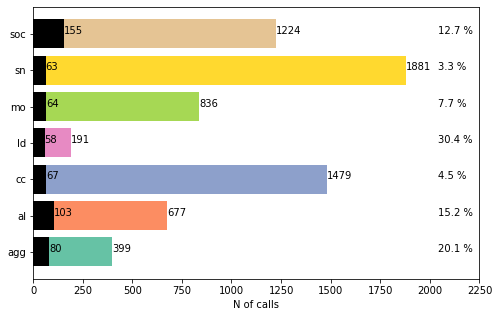

In [ ]:
 fig = plt.figure(figsize=(8,5))
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)
plt.barh(labelcounts.index, tab.mispositioned.values, color = 'black')
plt.xlabel("N of calls")
plt.xlim(0,2250)
for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

for index, value in enumerate(tab.mispositioned.values):
    plt.text(value, index, str(round(value,1)))
    #plt.text(value, index, str(round(tab.loc[tab.index[index],'mispositioned'],1))+"%")

for index, value in enumerate(tab.mispositioned.values):
    #plt.text(value, index, str(round(value,1)))
    plt.text(2040, index, str(round(tab.loc[tab.index[index],'percentage'],1))+" %")

plt.savefig(FIGURES+'misclassi_percent.png')

In [ ]:
# k=5
wrong_calls = wrong_df['call_lable']
hybfu_classi_neighbors = np.asarray(wrong_df[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
label_to_index = dict(zip(calltypes,np.arange(len(calltypes))))

hybfu_neighbor_tab = np.zeros((wrong_df.shape[0],len(calltypes)))

for i in range(wrong_df.shape[0]):
  neighbors = hybfu_classi_neighbors[i,:]
  for neighbor in neighbors:
    hybfu_neighbor_tab[i,label_to_index[neighbor]] += 20

hybfu_neighbor_tab = pd.DataFrame(hybfu_neighbor_tab)
hybfu_neighbor_tab.columns = calltypes
hybfu_neighbor_tab['label'] = wrong_calls
hybfu_neighbor_tab

agg    al     cc    ld     mo    sn    soc label
0     0.0   0.0   40.0   0.0    0.0   0.0   60.0    al
1     0.0   0.0    0.0   0.0  100.0   0.0    0.0    al
2     0.0   0.0    0.0   0.0   60.0   0.0   40.0   agg
3     0.0  20.0   80.0   0.0    0.0   0.0    0.0   agg
4     0.0   0.0  100.0   0.0    0.0   0.0    0.0   agg
..    ...   ...    ...   ...    ...   ...    ...   ...
585   0.0  20.0    0.0  20.0   60.0   0.0    0.0    cc
586   0.0   0.0    0.0   0.0    0.0   0.0  100.0    cc
587  20.0   0.0    0.0   0.0   20.0  60.0    0.0    cc
588  20.0  60.0    0.0   0.0    0.0   0.0   20.0    cc
589  60.0   0.0    0.0   0.0    0.0  20.0   20.0    cc

[590 rows x 8 columns]

In [ ]:
grouped = hybfu_neighbor_tab.groupby('label').mean()
numbers = pd.DataFrame(pd.Series(wrong_calls).value_counts())
numbers_dict = dict(zip(numbers.index, numbers.call_lable))
grouped.reset_index(inplace=True)
grouped = grouped[['label', 'agg', 'soc', 'cc', 'ld', 'mo', 'al', 'sn']]

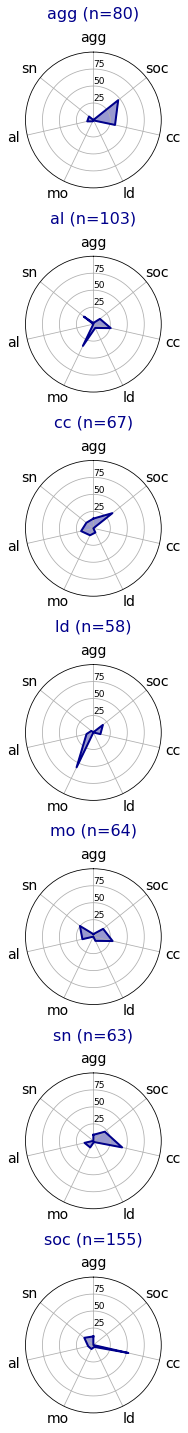

In [ ]:
def make_spider(row, title, color):
  # number of variable
  categories=list(grouped)[1:]
  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  
  # Initialise the spider plot
  ax = plt.subplot(7,1,row+1, polar=True, )
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories, color='black', size=14)
  
  # Draw ylabels
  ax.set_rlabel_position(0)
  plt.yticks([25,50,75], ["25","50","75"], color="black", size=9)
  plt.ylim(0,100)
  
  # Ind1
  values=grouped.loc[row].drop('label').values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
  ax.fill(angles, values, color=color, alpha=0.4)
  
  # Add a title
  plt.title(title, size=16, color=color, y=1.2)
 

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.figure(figsize=(10,20))

# Loop to plot
for row in range(0, len(grouped.index)):
  make_spider( row=row, title=grouped['label'][row]+" (n="+str(numbers_dict[grouped['label'][row]])+")", color="darkblue")

plt.tight_layout()
plt.savefig(FIGURES+'missclass_neighbors.png')

In [ ]:
from math import pi

In [ ]:
examples

index  row_num  ... neighbor_4_rownum neighbor_5_rownum
0    475     4826  ...              4414              4412
1    465     4717  ...              6039              5149
2    359     3294  ...              5170              5016
3    429     4407  ...              4841              4920

[4 rows x 13 columns]

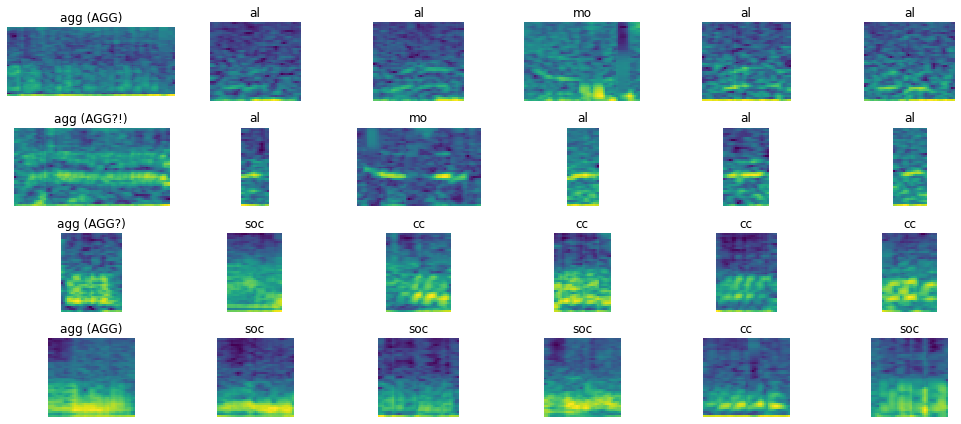

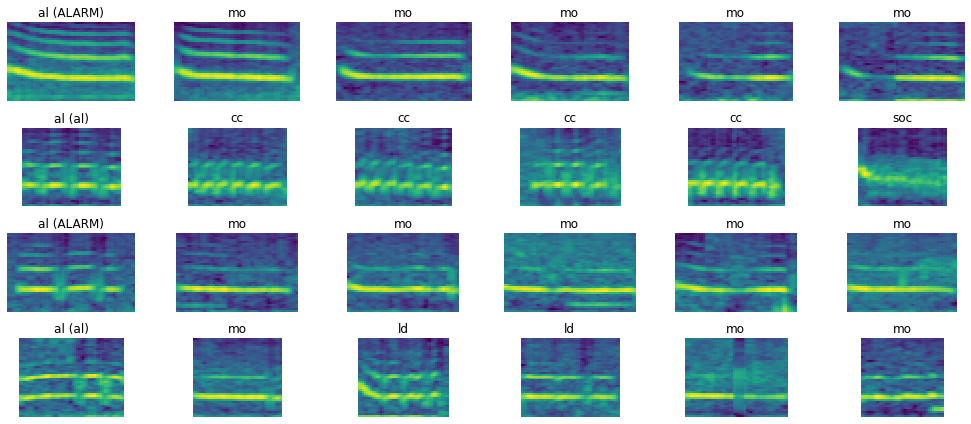

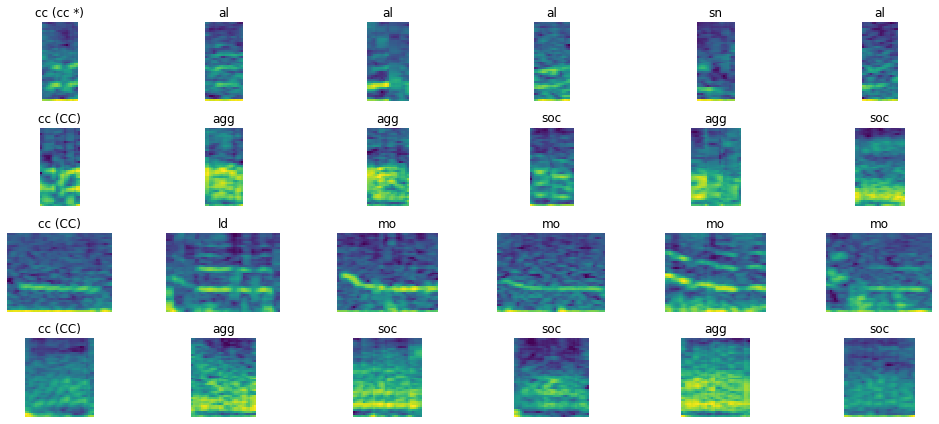

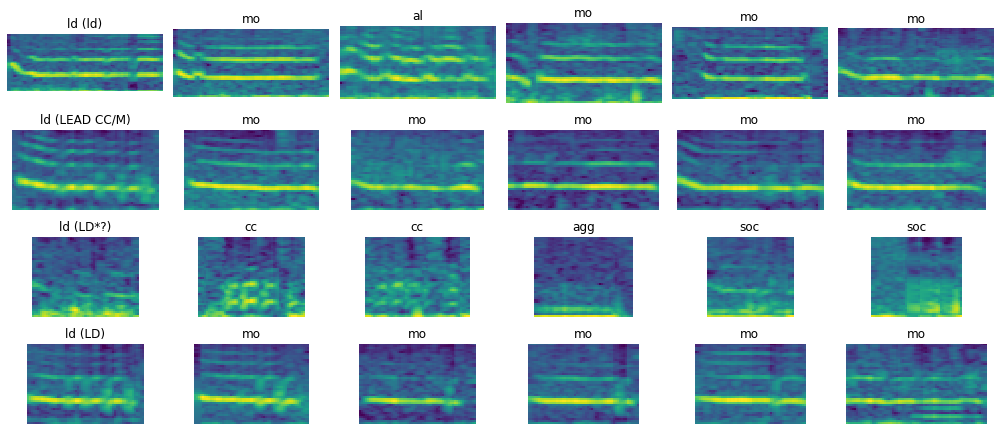

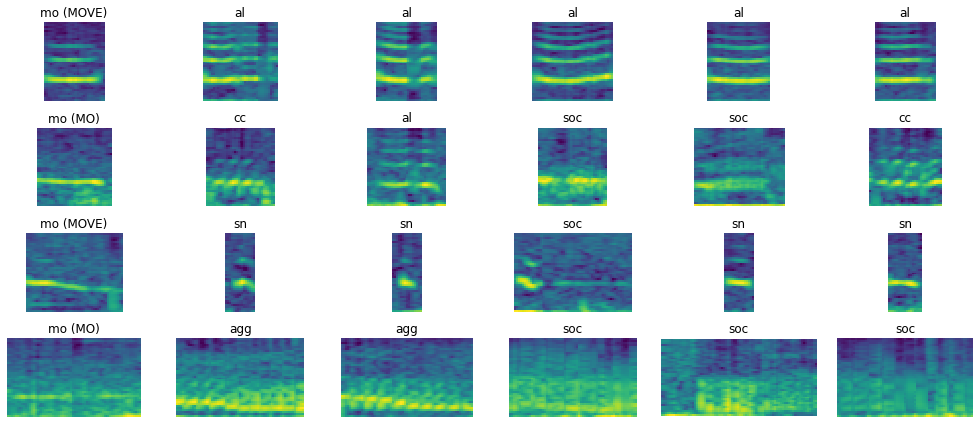

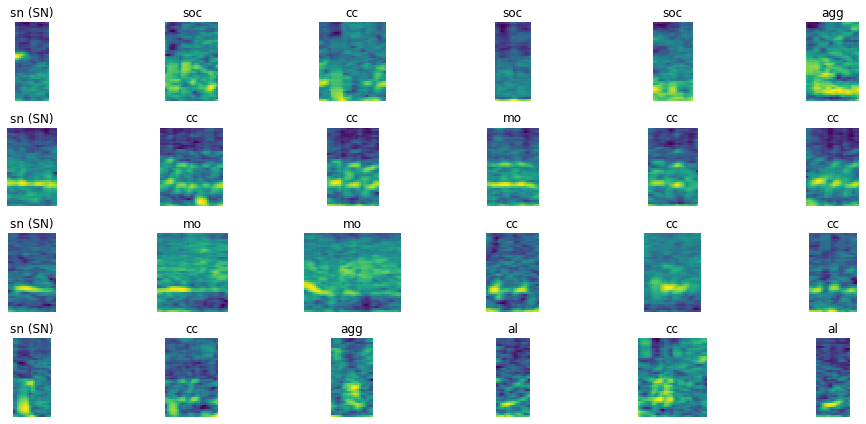

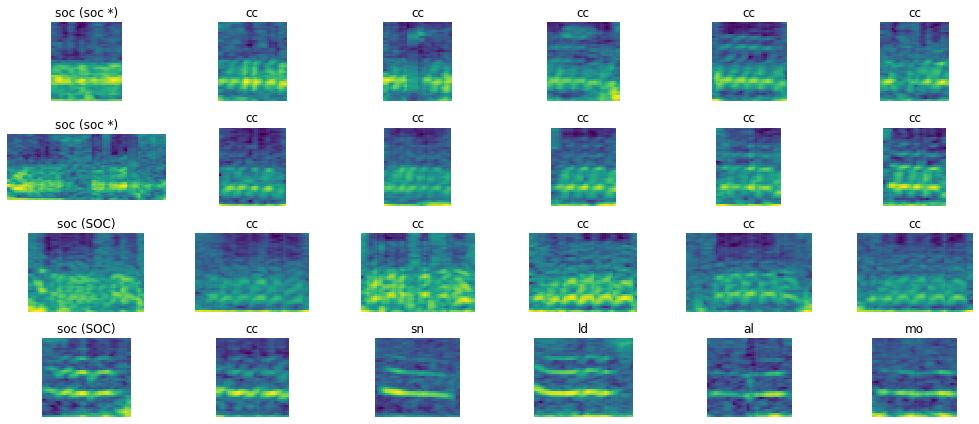

In [ ]:
# make plots

#spec_df.reset_index(inplace=True)

for calltype in calltypes:

  fig = plt.figure(figsize=(14,6))
  fig_name = 'NN_misclass_Viz_'+calltype
  k=1

  subset_df = wrong_df.loc[wrong_df['call_lable']==calltype,:]

  # randomly choose 4

  examples = subset_df.sample(n=4, random_state=2204)
  examples.reset_index(inplace=True)
  
  for i in range(examples.shape[0]):
    spec = spec_df.loc[examples.loc[i,'row_num'],'denoised_spectrograms']
    plt.subplot(4, 6, k)
    #librosa.display.specshow(np.transpose(spec))
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    plt.axis('off')
    original_name = spec_df.loc[examples.loc[i,'row_num'],'Name']
    plt.title(calltype+" ("+original_name+")")
    k=k+1

    for neighbor in range(1,6):
      neighbor_label = examples.loc[i,'neighbor_'+str(neighbor)]
      neighbor_spec = spec_df.loc[examples.loc[i,'neighbor_'+str(neighbor)+'_rownum'],'denoised_spectrograms']
      plt.subplot(4, 6, k)
      plt.imshow(neighbor_spec, interpolation='nearest', origin='lower', aspect='equal') 
      plt.axis('off')
      plt.title(examples.loc[i,'neighbor_'+str(neighbor)])
      k=k+1
        
  plt.tight_layout() 
  plt.savefig(FIGURES+fig_name)

In [ ]:
calltype = 'al'

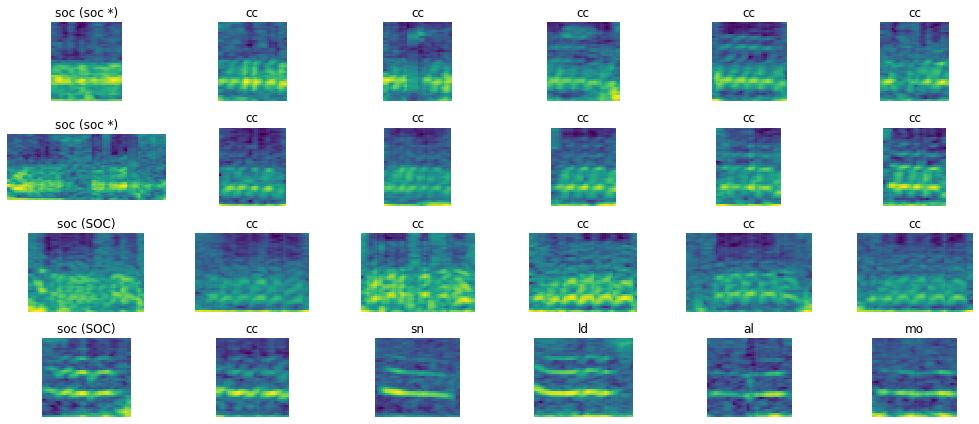

In [ ]:
  fig = plt.figure(figsize=(14,6))
  fig_name = 'NN_misclass_Viz_'+calltype
  k=1

  subset_df = wrong_df.loc[wrong_df['call_lable']==calltype,:]

  # randomly choose 3

  examples = subset_df.sample(n=4, random_state=2204)
  examples.reset_index(inplace=True)
  
  for i in range(examples.shape[0]):
    spec = spec_df.loc[examples.loc[i,'row_num'],'denoised_spectrograms']
    plt.subplot(4, 6, k)
    #librosa.display.specshow(np.transpose(spec))
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    plt.axis('off')
    original_name = spec_df.loc[examples.loc[i,'row_num'],'Name']
    plt.title(calltype+" ("+original_name+")")
    #plt.title(calltype)
    k=k+1

    for neighbor in range(1,6):
      neighbor_label = examples.loc[i,'neighbor_'+str(neighbor)]
      neighbor_spec = spec_df.loc[examples.loc[i,'neighbor_'+str(neighbor)+'_rownum'],'denoised_spectrograms']
      plt.subplot(4, 6, k)
      plt.imshow(neighbor_spec, interpolation='nearest', origin='lower', aspect='equal') 
      plt.axis('off')
      plt.title(examples.loc[i,'neighbor_'+str(neighbor)])
      k=k+1
        
  plt.tight_layout() 
  plt.show()

# Effect of call duration

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n']
df.shape

(6687, 35)

In [ ]:
labels = df.call_lable.values
calltypes = sorted(list(set(labels)))

In [ ]:
embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal' 
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = np.asarray(embedding)[:,0:5]
embedding.shape

(6687, 5)

In [ ]:
k=5

indices, distances = get_knn(k,embedding)

neighbors = []

for i in range(embedding.shape[0]):
  neighbor_labels = [labels[ind] for ind in indices[i]]
  neighbors.append(neighbor_labels)

In [ ]:
a = df[['call_lable', 'duration_s', 'index_id']]
for i in range(k):
  a['neighbor_'+str(i+1)] = [neighbor[i] for neighbor in neighbors]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
misclassi_yn = []

for i in range(df.shape[0]):
  if labels[i] not in neighbors[i]:
    misclassi_yn.append('y')
  else:
    misclassi_yn.append('n')

In [ ]:
a['misclass_yn'] = misclassi_yn

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
sameclass_3_yn = []

for i in range(df.shape[0]):
  val_counts = pd.DataFrame(pd.Series(neighbors[i]).value_counts())

  if labels[i] in val_counts.index:
    if val_counts.loc[labels[i],0] >= 3:
      sameclass_3_yn.append('y')
    else:
      sameclass_3_yn.append('n')
  else:
    sameclass_3_yn.append('n')

In [ ]:
a['sameclass_3_yn'] = sameclass_3_yn

In [ ]:
a['sameclass_3_yn'].value_counts()

y    5027
n    1660
Name: sameclass_3_yn, dtype: int64

In [ ]:
fig = plt.figure(figsize=(10, 6))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in zip([1,2,3,5,6,7,8],calltypes):
  subset_df = a[a['call_lable']==calltype]
  subset_cor = subset_df[subset_df['sameclass_3_yn']=='y']
  subset_miss = subset_df[subset_df['misclass_yn']=='y']
  subset_medium = subset_df[subset_df['sameclass_3_yn']=='n']
  subset_medium = subset_medium[subset_medium['misclass_yn']=='n']

  plt.subplot(2, 4, i)

  data = [subset_cor.duration_s.values,
          subset_medium.duration_s.values,
          subset_miss.duration_s.values]

  bp = plt.boxplot(data,
            labels= ['Correct', 
                     'Mixed',
                     'Incorrect'],
            showmeans= True,
            patch_artist = True,
            showfliers=False)
  
  plt.text(0.8,0.59, str(round(np.mean(data[0]),2)))
  plt.text(1.8,0.59, str(round(np.mean(data[1]),2)))
  plt.text(2.8,0.59, str(round(np.mean(data[2]),2)))
  
  plt.text(0.8,0.54, u"\u00B1"+str(round(np.std(data[0]),2)))
  plt.text(1.8,0.54, u"\u00B1"+str(round(np.std(data[1]),2)))
  plt.text(2.8,0.54, u"\u00B1"+str(round(np.std(data[2]),2)))

  for patch in bp['boxes']:
    patch.set_facecolor(color_dict[calltype])

 
  #s, pval = stats.ttest_ind(data[0],data[1])
  pval = stats.f_oneway(data[0],data[1], data[2]).pvalue
  
  #pval = res.pvalue)
  if pval<0.01:
    pval = "p<0.01"
  else:
    pval = "p="+str(round(pval,3))
  plt.title(calltype+" ("+pval+")")
  plt.ylim(0,0.65)

plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_effect_call_duration.png')

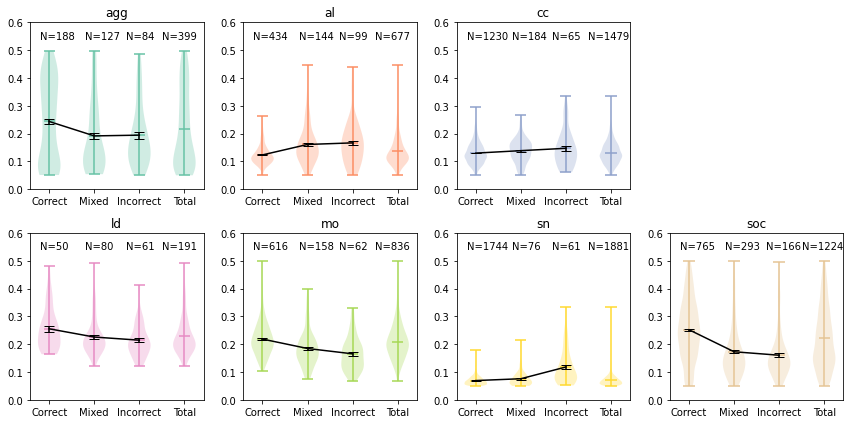

In [ ]:
fig = plt.figure(figsize=(12, 6))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in zip([1,2,3,5,6,7,8],calltypes):
  subset_df = a[a['call_lable']==calltype]
  subset_cor = subset_df[subset_df['sameclass_3_yn']=='y']
  subset_miss = subset_df[subset_df['misclass_yn']=='y']
  subset_medium = subset_df[subset_df['sameclass_3_yn']=='n']
  subset_medium = subset_medium[subset_medium['misclass_yn']=='n']

  plt.subplot(2, 4, i)

  data = [subset_cor.duration_s.values,
          subset_medium.duration_s.values,
          subset_miss.duration_s.values, 
          subset_df.duration_s.values]

  bp = plt.violinplot(data,
                      showmeans=True)
                      #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])


  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[calltype])

  for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[calltype])

  plt.errorbar([1,2,3], 
               [np.mean(data[0]), np.mean(data[1]), np.mean(data[2])], 
               #yerr=[np.std(data[0]), np.std(data[1]), np.std(data[2])], 
               yerr = [stats.sem(data[0]), stats.sem(data[1]), stats.sem(data[2])],
               capsize=5, color = 'black')

  
  #plt.text(0.8,0.59, u"\u03BC"+"="+str(round(np.mean(data[0]),2)))
  #plt.text(1.8,0.59, u"\u03BC"+"="+str(round(np.mean(data[1]),2)))
  #plt.text(2.6,0.59, u"\u03BC"+"="+str(round(np.mean(data[2]),2)))
  
  #plt.text(0.95,0.54, u"\u00B1"+str(round(np.std(data[0]),2)))
  #plt.text(1.95,0.54, u"\u00B1"+str(round(np.std(data[1]),2)))
  #plt.text(2.75,0.54, u"\u00B1"+str(round(np.std(data[2]),2)))

  plt.text(0.8,0.54, "N="+str(data[0].shape[0]))
  plt.text(1.8,0.54, "N="+str(data[1].shape[0]))
  plt.text(2.7,0.54, "N="+str(data[2].shape[0]))
  plt.text(3.5,0.54, "N="+str(data[3].shape[0]))

  plt.xticks([1,2,3,4],['Correct', 
                      'Mixed', 
                      'Incorrect',
                      'Total'])

  #for patch in bp['boxes']:
  #  patch.set_facecolor(color_dict[calltype])

 
  #s, pval = stats.ttest_ind(data[0],data[1])
  pval = stats.f_oneway(data[0],data[1], data[2]).pvalue
  
  #pval = res.pvalue)
  if pval<0.01:
    pval = "p<0.01"
  else:
    pval = "p="+str(round(pval,3))
  #plt.title(calltype+" ("+pval+")")
  plt.title(calltype)
  plt.ylim(0,0.6)

plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_effect_call_duration_violin_sem.png')

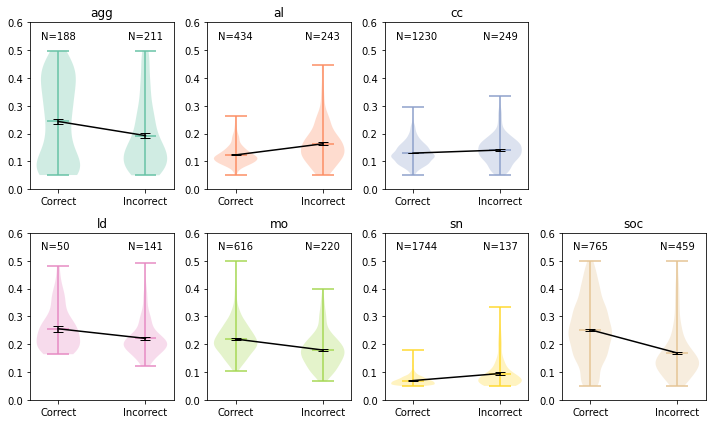

In [ ]:
fig = plt.figure(figsize=(10, 6))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in zip([1,2,3,5,6,7,8],calltypes):
  subset_df = a[a['call_lable']==calltype]
  subset_cor = subset_df[subset_df['sameclass_3_yn']=='y']
  subset_miss = subset_df[subset_df['sameclass_3_yn']=='n']

  plt.subplot(2, 4, i)

  data = [subset_cor.duration_s.values,
          subset_miss.duration_s.values]

  bp = plt.violinplot(data,
                      showmeans=True)
                      #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])


  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[calltype])

  for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[calltype])

  plt.errorbar([1,2], 
               [np.mean(data[0]), np.mean(data[1])], 
               yerr = [stats.sem(data[0]), stats.sem(data[1])],
               #yerr=[np.std(data[0]), np.std(data[1])], 
               capsize=5, color = 'black')


  plt.text(0.8,0.54, "N="+str(data[0].shape[0]))
  plt.text(1.8,0.54, "N="+str(data[1].shape[0]))

  plt.xticks([1,2],['Correct', 
                    'Incorrect'])

  plt.title(calltype)
  plt.ylim(0,0.6)

plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_effect_call_duration_violin_dual.png')

Number of same-class nearest neighbors plotted against call duration!!

In [ ]:
sameclass_nbs = []

for i in range(df.shape[0]):
  val_counts = pd.DataFrame(pd.Series(neighbors[i]).value_counts())

  if labels[i] in val_counts.index:
    sameclass_nbs.append(val_counts.loc[labels[i],0])
  else:
    sameclass_nbs.append(0)

In [ ]:
a['sameclass_nbs'] = sameclass_nbs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



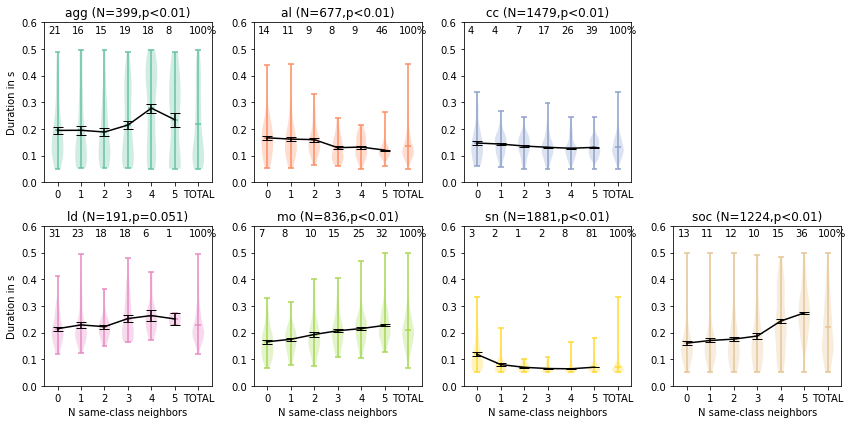

In [ ]:
fig = plt.figure(figsize=(12, 6))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in zip([1,2,3,5,6,7,8],calltypes):
  subset_df = a[a['call_lable']==calltype]
  mylevels = [0,1,2,3,4,5]
  plt.subplot(2, 4, i)

  #data = [subset_0,subset_1,subset_2,subset_3,subset_4,subset_5]
  data = [subset_df[subset_df['sameclass_nbs']==x] for x in mylevels]
  data = [x.duration_s.values for x in data]
  data = data+[subset_df.duration_s.values]

  bp = plt.violinplot(data,
                      showmeans=True)
                      #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])


  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[calltype])

  for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[calltype])

  plt.errorbar([1,2,3,4,5,6], 
               [np.mean(data[x]) for x in mylevels],
               yerr = [stats.sem(data[x]) for x in mylevels],
               capsize=5, color = 'black')

  for xpos_i,xpos in enumerate([0.6,1.6,2.6,3.6,4.6,5.6,6.6]):
    #plt.text(xpos,0.56, str(data[xpos_i].shape[0]))
    #plt.text(xpos,0.51, str(int(data[xpos_i].shape[0]/subset_df.shape[0]*100))+"%")
    if xpos_i==6:
      plt.text(xpos,0.56, str(int(data[xpos_i].shape[0]/subset_df.shape[0]*100))+"%")
    else:
      plt.text(xpos,0.56, str(int(data[xpos_i].shape[0]/subset_df.shape[0]*100)))


  plt.xticks([1,2,3,4,5,6,7], [str(x) for x in mylevels+['TOTAL']])

  #plt.title(calltype)
  if i in [1,5]:
    plt.ylabel('Duration in s')
  if i>4:
    plt.xlabel('N same-class neighbors')
  plt.ylim(0,0.6)

  pval = stats.f_oneway(data[0],data[1],data[2], data[3],data[4],data[5]).pvalue
  
  #pval = res.pvalue)
  if pval<0.01:
    pval = "p<0.01"
  else:
    pval = "p="+str(round(pval,3))
  plt.title(calltype+" (N="+str(subset_df.shape[0])+","+pval+")")
  #plt.title(calltype)

plt.tight_layout()
#plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_duration_nbs.png')

In [ ]:
import scipy.stats as stats

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



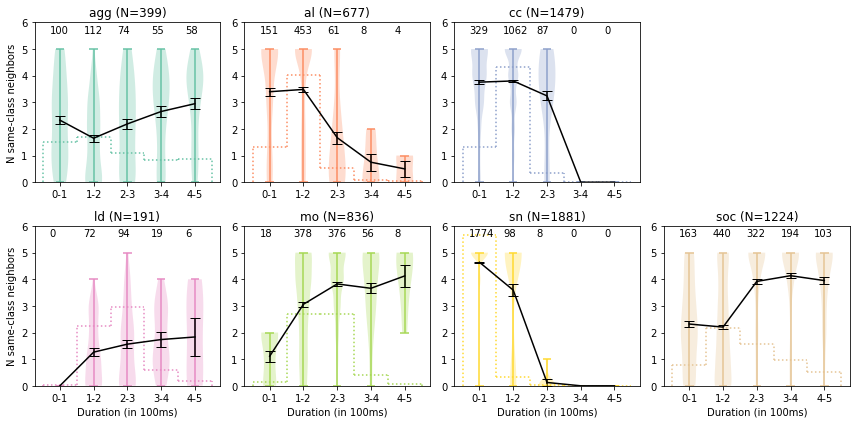

In [ ]:
fig = plt.figure(figsize=(12, 6))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in zip([1,2,3,5,6,7,8],calltypes):
  subset_df = a[a['call_lable']==calltype].copy()
  subset_durations = subset_df.duration_s.values
  # alternative
  bins = np.arange(0., 0.55, 0.1)
  bin_labels = np.digitize(subset_durations, bins)
  subset_df['bin_labels'] = bin_labels

  mylevels = [1,2,3,4,5]
  plt.subplot(2, 4, i)

  data = [subset_df[subset_df['bin_labels']==x] for x in mylevels]
  data = [x.sameclass_nbs.values for x in data]

  for j,dat in enumerate(data):
    if dat.shape[0]==0:
      data[j] = np.asarray([0])
      #if dat[0]==0:
        #data[i] = np.asarray([0,0,0])
  

  #data = data+[subset_df.duration_s.values]

  bp = plt.violinplot(data)
                      #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])


  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[calltype])

  for partname in ('cbars','cmins','cmaxes'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[calltype])

  plt.errorbar([1,2,3,4,5], 
               [np.mean(data[x]) for x in [0,1,2,3,4]],
               yerr = [stats.sem(data[x]) for x in [0,1,2,3,4]],
               capsize=5, color = 'black')
  
  last_level = 0
  for xpos_i, xcord in zip([0,1,2,3,4], [0.7,1.7,2.7,3.7,4.7]):
    scaled_height = (data[xpos_i].shape[0]/subset_df.shape[0])*6
    plt.hlines(y=scaled_height, xmin=xpos_i+0.5, xmax=xpos_i+1.5, color=color_dict[calltype], linestyles='dotted')
    new_level = scaled_height

    plt.vlines(x=xpos_i+0.5, 
               ymin=np.min(np.asarray([last_level, scaled_height])), 
               ymax=np.max(np.asarray([last_level, scaled_height])),
               color=color_dict[calltype],
               linestyles='dotted')
    last_level = new_level
  
  plt.vlines(x=5+0.5,ymin=0,ymax=last_level,color=color_dict[calltype],linestyles='dotted')
    


    #n = str(data[xpos_i].shape[0])
    #if n=='1':
    #  n='0'
    #plt.text(xcord,scaled_height-0.5, n)
  
  #plt.hlines(y=0.5, xmin=0, xmax=1, color=color_dict[calltype])


  for xpos_i,xpos in enumerate([0.7,1.7,2.7,3.7,4.7]):
    n = str(data[xpos_i].shape[0])
    if n=='1':
      n='0'
    plt.text(xpos,5.6, n)
    #plt.text(xpos,5.6, str(round(data[xpos_i].shape[0]/subset_df.shape[0]*100,1))+"%")

  durbins = ['0-1', '1-2', '2-3', '3-4','4-5']
  plt.xticks([1,2,3,4,5], durbins)

  #plt.xticks([1,2,3,4,5], [str(x) for x in [1,2,3,4,5]])

  plt.ylim(0,6)

  if i in [1,5]:
    plt.ylabel('N same-class neighbors')
  if i>4:
    plt.xlabel('Duration (in 100ms)')

  pval = stats.f_oneway(data[0],data[1],data[2], data[3],data[4]).pvalue
  
  #pval = res.pvalue)
  if pval<0.01:
    pval = "p<0.01"
  else:
    pval = "p="+str(round(pval,3))
  #plt.title(calltype+" ("+pval+")")
  plt.title(calltype+" (N="+str(subset_df.shape[0])+")")

  


plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_duration_bins_stretched_df.png')

In [ ]:
fig = plt.figure(figsize=(12, 6))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in zip([1,2,3,5,6,7,8],calltypes):
  subset_df = a[a['call_lable']==calltype].copy()
  subset_durations = subset_df.duration_s.values
  # alternative
  bins = np.arange(0., 0.55, 0.1)
  bin_labels = np.digitize(subset_durations, bins)
  subset_df['bin_labels'] = bin_labels

  mylevels = [1,2,3,4,5]
  plt.subplot(2, 4, i)

  data = [subset_df[subset_df['bin_labels']==x] for x in mylevels]
  data = [x.sameclass_nbs.values for x in data]

  for j,dat in enumerate(data):
    if dat.shape[0]==0:
      data[j] = np.asarray([0])
      #if dat[0]==0:
        #data[i] = np.asarray([0,0,0])
  

  #data = data+[subset_df.duration_s.values]

  bp = plt.violinplot(data)
                      #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])


  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[calltype])

  for partname in ('cbars','cmins','cmaxes'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[calltype])

  plt.errorbar([1,2,3,4,5], 
               [np.mean(data[x]) for x in [0,1,2,3,4]],
               yerr = [stats.sem(data[x]) for x in [0,1,2,3,4]],
               capsize=5, color = 'black')
  
  last_level = 0
  for xpos_i, xcord in zip([0,1,2,3,4], [0.7,1.7,2.7,3.7,4.7]):
    scaled_height = (data[xpos_i].shape[0]/subset_df.shape[0])*6
    plt.hlines(y=scaled_height, xmin=xpos_i+0.5, xmax=xpos_i+1.5, color=color_dict[calltype], linestyles='dotted')
    new_level = scaled_height

    plt.vlines(x=xpos_i+0.5, 
               ymin=np.min(np.asarray([last_level, scaled_height])), 
               ymax=np.max(np.asarray([last_level, scaled_height])),
               color=color_dict[calltype],
               linestyles='dotted')
    last_level = new_level
  
  plt.vlines(x=5+0.5,ymin=0,ymax=last_level,color=color_dict[calltype],linestyles='dotted')
    


    #n = str(data[xpos_i].shape[0])
    #if n=='1':
    #  n='0'
    #plt.text(xcord,scaled_height-0.5, n)
  
  #plt.hlines(y=0.5, xmin=0, xmax=1, color=color_dict[calltype])


  for xpos_i,xpos in enumerate([0.7,1.7,2.7,3.7,4.7]):
    n = str(data[xpos_i].shape[0])
    if n=='1':
      n='0'
    plt.text(xpos,5.6, n)
    #plt.text(xpos,5.6, str(round(data[xpos_i].shape[0]/subset_df.shape[0]*100,1))+"%")

  durbins = ['0-1', '1-2', '2-3', '3-4','4-5']
  plt.xticks([1,2,3,4,5], durbins)

  #plt.xticks([1,2,3,4,5], [str(x) for x in [1,2,3,4,5]])

  plt.ylim(0,6)

  if i in [1,5]:
    plt.ylabel('N same-class neighbors')
  if i>4:
    plt.xlabel('Duration (in 100ms)')

  pval = stats.f_oneway(data[0],data[1],data[2], data[3],data[4]).pvalue
  
  #pval = res.pvalue)
  if pval<0.01:
    pval = "p<0.01"
  else:
    pval = "p="+str(round(pval,3))
  #plt.title(calltype+" ("+pval+")")
  plt.title(calltype+" (N="+str(subset_df.shape[0])+")")


plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_duration_bins_stretched_df.png')

# Correlation between original and embedded space

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
# balanced, focal-only dataset
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']

In [ ]:
# embedding
embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal'
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = embedding[:,0:5]

In [ ]:
specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

In [ ]:
distmat = squareform(pdist(data, metric='euclidean'))

In [ ]:
distmat_embedded = squareform(pdist(embedding, metric='euclidean'))

In [ ]:
print(distmat.shape)
print(distmat_embedded.shape)

(6687, 6687)
(6687, 6687)


## Mantel test

In [ ]:
!pip install scikit-bio
from skbio.stats.distance import mantel

In [ ]:
r,p,z = test(distmat, distmat_embedded, perms=100, method='spearman')

In [ ]:
print(r)
print(p)
print(z)

0.3288574175992129
0.01
9.790774055832685


In [ ]:
r,p,z = test(distmat, distmat_embedded, perms=1000, method='spearman')

In [ ]:
print(r)
print(p)
print(z)

0.3288574175992129
0.001
27.089003144965837


In [ ]:
r,p,z = test(distmat, distmat_embedded, perms=100, method='pearson')
print(r)
print(p)
print(z)

In [ ]:
# MantelTest v1.2.10
# http://jwcarr.github.io/MantelTest/
#
# Copyright (c) 2014-2016 Jon W. Carr
# Licensed under the terms of the MIT License

import numpy as np
from itertools import permutations
from scipy import spatial, stats

def test(X, Y, perms=10000, method='pearson', tail='two-tail'):
  """
  Takes two distance matrices (either redundant matrices or condensed vectors)
  and performs a Mantel test. The Mantel test is a significance test of the
  correlation between two distance matrices.
  Parameters
  ----------
  X : array_like
      First distance matrix (condensed or redundant).
  Y : array_like
      Second distance matrix (condensed or redundant), where the order of
      elements corresponds to the order of elements in the first matrix.
  perms : int, optional
      The number of permutations to perform (default: 10000). A larger number
      gives more reliable results but takes longer to run. If the actual number
      of possible permutations is smaller, the program will enumerate all
      permutations. Enumeration can be forced by setting this argument to 0.
  method : str, optional
      Type of correlation coefficient to use; either 'pearson' or 'spearman'
      (default: 'pearson').
  tail : str, optional
      Which tail to test in the calculation of the empirical p-value; either
      'upper', 'lower', or 'two-tail' (default: 'two-tail').
  Returns
  -------
  r : float
      Veridical correlation
  p : float
      Empirical p-value
  z : float
      Standard score (z-score)
  """

  # Ensure that X and Y are formatted as Numpy arrays.
  X, Y = np.asarray(X, dtype=float), np.asarray(Y, dtype=float)

  # Check that X and Y are valid distance matrices.
  if spatial.distance.is_valid_dm(X) == False and spatial.distance.is_valid_y(X) == False:
    raise ValueError('X is not a valid condensed or redundant distance matrix')
  if spatial.distance.is_valid_dm(Y) == False and spatial.distance.is_valid_y(Y) == False:
    raise ValueError('Y is not a valid condensed or redundant distance matrix')

  # If X or Y is a redundant distance matrix, reduce it to a condensed distance matrix.
  if len(X.shape) == 2:
    X = spatial.distance.squareform(X, force='tovector', checks=False)
  if len(Y.shape) == 2:
    Y = spatial.distance.squareform(Y, force='tovector', checks=False)

  # Check for size equality.
  if X.shape[0] != Y.shape[0]:
    raise ValueError('X and Y are not of equal size')

  # Check for minimum size.
  if X.shape[0] < 3:
    raise ValueError('X and Y should represent at least 3 objects')

  # If Spearman correlation is requested, convert X and Y to ranks.
  if method == 'spearman':
    X, Y = stats.rankdata(X), stats.rankdata(Y)

  # Check for valid method parameter.
  elif method != 'pearson':
    raise ValueError('The method should be set to "pearson" or "spearman"')

  # Check for valid tail parameter.
  if tail != 'upper' and tail != 'lower' and tail != 'two-tail':
    raise ValueError('The tail should be set to "upper", "lower", or "two-tail"')

  # Now we're ready to start the Mantel test using a number of optimizations:
  #
  # 1. We don't need to recalculate the pairwise distances between the objects
  #    on every permutation. They've already been calculated, so we can use a
  #    simple matrix shuffling technique to avoid recomputing them. This works
  #    like memoization.
  #
  # 2. Rather than compute correlation coefficients, we'll just compute the
  #    covariances. This works because the denominator in the equation for the
  #    correlation coefficient will yield the same result however the objects
  #    are permuted, making it redundant. Removing the denominator leaves us
  #    with the covariance.
  #
  # 3. Rather than permute the Y distances and derive the residuals to calculate
  #    the covariance with the X distances, we'll represent the Y residuals in
  #    the matrix and shuffle those directly.
  #
  # 4. If the number of possible permutations is less than the number of
  #    permutations that were requested, we'll run a deterministic test where
  #    we try all possible permutations rather than sample the permutation
  #    space. This gives a faster, deterministic result.

  # Calculate the X and Y residuals, which will be used to compute the
  # covariance under each permutation.
  X_residuals, Y_residuals = X - X.mean(), Y - Y.mean()

  # Expand the Y residuals to a redundant matrix.
  Y_residuals_as_matrix = spatial.distance.squareform(Y_residuals, force='tomatrix', checks=False)

  # Get the number of objects.
  m = Y_residuals_as_matrix.shape[0]

  # Calculate the number of possible matrix permutations.
  n = np.math.factorial(m)

  # Initialize an empty array to store temporary permutations of Y_residuals.
  Y_residuals_permuted = np.zeros(Y_residuals.shape[0], dtype=float)

  # If the number of requested permutations is greater than the number of
  # possible permutations (m!) or the perms parameter is set to 0, then run a
  # deterministic Mantel test ...
  if perms >= n or perms == 0:

    # Initialize an empty array to store the covariances.
    covariances = np.zeros(n, dtype=float)

    # Enumerate all permutations of row/column orders and iterate over them.
    for i, order in enumerate(permutations(range(m))):

      # Take a permutation of the matrix.
      Y_residuals_as_matrix_permuted = Y_residuals_as_matrix[order, :][:, order]

      # Condense the permuted version of the matrix. Rather than use
      # distance.squareform(), we call directly into the C wrapper for speed.
      spatial.distance._distance_wrap.to_vector_from_squareform_wrap(Y_residuals_as_matrix_permuted, Y_residuals_permuted)

      # Compute and store the covariance.
      covariances[i] = (X_residuals * Y_residuals_permuted).sum()

  # ... otherwise run a stochastic Mantel test.
  else:

    # Initialize an empty array to store the covariances.
    covariances = np.zeros(perms, dtype=float)

    # Initialize an array to store the permutation order.
    order = np.arange(m)

    # Store the veridical covariance in 0th position...
    covariances[0] = (X_residuals * Y_residuals).sum()

    # ...and then run the random permutations.
    for i in range(1, perms):

      # Choose a random order in which to permute the rows and columns.
      np.random.shuffle(order)

      # Take a permutation of the matrix.
      Y_residuals_as_matrix_permuted = Y_residuals_as_matrix[order, :][:, order]

      # Condense the permuted version of the matrix. Rather than use
      # distance.squareform(), we call directly into the C wrapper for speed.
      spatial.distance._distance_wrap.to_vector_from_squareform_wrap(Y_residuals_as_matrix_permuted, Y_residuals_permuted)

      # Compute and store the covariance.
      covariances[i] = (X_residuals * Y_residuals_permuted).sum()

  # Calculate the veridical correlation coefficient from the veridical covariance.
  r = covariances[0] / np.sqrt((X_residuals ** 2).sum() * (Y_residuals ** 2).sum())

  # Calculate the empirical p-value for the upper or lower tail.
  if tail == 'upper':
    p = (covariances >= covariances[0]).sum() / float(covariances.shape[0])
  elif tail == 'lower':
    p = (covariances <= covariances[0]).sum() / float(covariances.shape[0])
  elif tail == 'two-tail':
    p = (abs(covariances) >= abs(covariances[0])).sum() / float(covariances.shape[0])

  # Calculate the standard score.
  z = (covariances[0] - covariances.mean()) / covariances.std()

  return r, p, z

In [ ]:
#x = mantel(distmat, distmat_embedded, method='spearman')

In [ ]:
print(round(coeff, 4))
print(round(p_value,4))

## Boxplot

Box plots represent distances across pairs of points in the embeddings, binned using 50 equal-width bins over the pairwise distances in the original space using 10,000 randomly selected points, leading to 49,995,000 pairs of pairwise distances. The last row of graphs represents counts of pairwise distances in each bin of distances from the original space as histograms. The value of the Pearson correlation coefficient computed over the pairs of pairwise distances is reported. For the box plots, the central bar represents the median, and the top and bottom boundary of the boxes represent the 75th and 25th percentiles, respectively. The whiskers represent 1.5 times the interquartile range above (or, respectively, below) the top (or, respectively, bottom) box boundary, truncated to the data range if applicable.

https://www.nature.com/articles/nbt.4314#Sec7

https://www.biorxiv.org/content/10.1101/2019.12.19.877522v1

In [ ]:
# Generate 50 equal-width bins from the pairwise-distances in original space
# and assign each pairwise distance a bin (or make mask for each bin)

# Use the same mask to filter the paiwirse distances in embedded space
# Boxplot of the average distance in that area

# Plot all 50 boxplots next to each other

In [ ]:
# Concatenate all relevant ones
all_dists = []

for i in range(distmat.shape[0]):
  all_dists.append(distmat[i,0:i])
  
all_dists_vec = np.hstack(all_dists).flatten()

In [ ]:
all_dists_embedded = []

for i in range(distmat_embedded.shape[0]):
  all_dists_embedded.append(distmat_embedded[i,0:i])
all_dists_embedded_vec = np.hstack(all_dists_embedded).flatten()

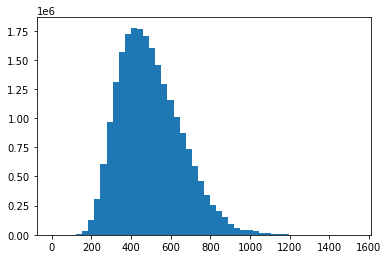

In [ ]:
n, bins, batches = plt.hist(all_dists_vec, bins=50)

In [ ]:
bin_labels = np.digitize(all_dists_vec, bins, right=True)   

In [ ]:
# alternative
bins = np.linspace(np.min(all_dists_vec), np.max(all_dists_vec), 50)
bin_labels = np.digitize(all_dists_vec, bins)  

In [ ]:
av_bin_labels = set(bin_labels)

In [ ]:
bin_data_dict = {}
for bin_label in av_bin_labels:
  bin_data_dict[bin_label] = all_dists_embedded_vec[np.where(bin_labels==bin_label)]

In [ ]:
for i in np.arange(1,51,1):
  if i not in av_bin_labels:
    print(i)
    bin_data_dict[i] = np.asarray([])

2
48
49


In [ ]:
np.mean(bin_data_dict[50])

2.5993306308006097

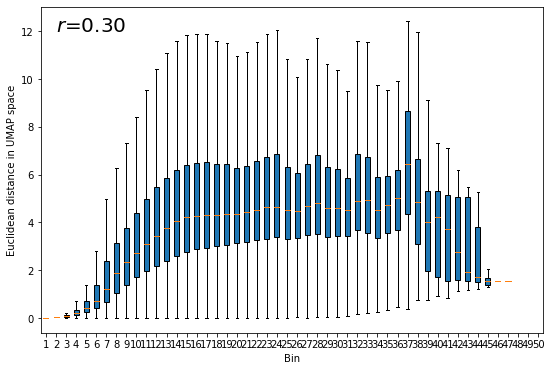

In [ ]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(bin_data_dict.values(), patch_artist=True, showfliers=False)
ax.set_xlabel('Bin')
ax.set_ylabel('Euclidean distance in UMAP space')
t = ax.text(2, 12, '$r$=0.30', fontsize=20)
# Save the figure
fig.savefig(FIGURES+'Corr_no_outlier.png', bbox_inches='tight')

In [ ]:
all_means = [np.mean(bin_data_dict[x]) for x in bin_data_dict.keys()]

(0.0, 12.0)

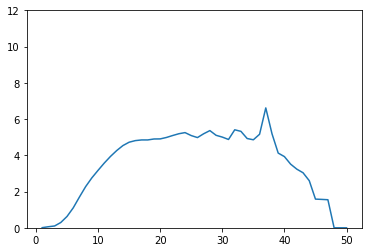

In [ ]:
all_means = [np.mean(bin_data_dict[x]) for x in bin_data_dict.keys()]

plt.plot(np.arange(1,51,1), all_means)
plt.ylim(0,12)

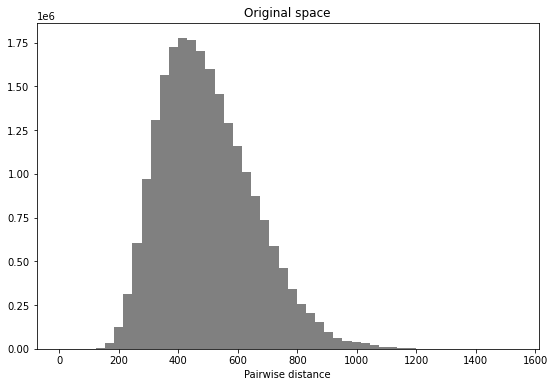

In [ ]:
fig = plt.figure(1, figsize=(9, 6))
n, bins, batches = plt.hist(all_dists_vec, bins=50, color='grey')
plt.title('Original space')
plt.xlabel('Pairwise distance')
fig.savefig(FIGURES+'original_hist.png', bbox_inches='tight')

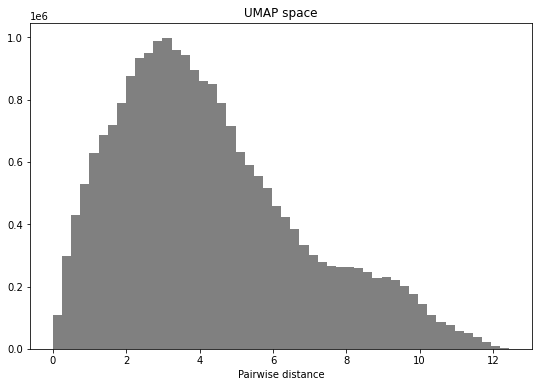

In [ ]:
fig = plt.figure(1, figsize=(9, 6))
plt.title('UMAP space')
plt.xlabel('Pairwise distance')
n, bins, batches = plt.hist(all_dists_embedded_vec, bins=50, color='grey')
fig.savefig(FIGURES+'embedded_hist.png', bbox_inches='tight')

In [ ]:
count=0

for i in range(38,50,1):
  count += bin_data_dict[i].shape[0]

count/(all_dists_vec.shape[0]/100)

0.034833930010327606

In [ ]:
bins[16]

501.3176533512901

In [ ]:
pearsonr(all_dists_vec[np.where(all_dists_vec<532.6)], all_dists_embedded_vec[np.where(all_dists_vec<532.6)])

(0.3646874446447922, 0.0)

In [ ]:
pearsonr(all_dists_vec[np.where(all_dists_vec<501.3)], all_dists_embedded_vec[np.where(all_dists_vec<501.3)])

(0.3689305400636829, 0.0)

In [ ]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
pearsonr(all_dists_vec, all_dists_embedded_vec)

(0.2966578181375995, 0.0)

In [ ]:
spearmanr(all_dists_vec, all_dists_embedded_vec)

SpearmanrResult(correlation=0.3288574175992152, pvalue=0.0)

# Within-class vs outside-class distances

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n']
# embedding
embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal'
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = embedding[:,0:5]

labels = df.call_lable.values
calltypes = sorted(list(set(labels)))

In [ ]:
distmat_embedded = squareform(pdist(embedding, metric='euclidean'))

In [ ]:
labels = np.asarray(labels)

self_dists={}
other_dists={}

for calltype in calltypes:
  x=distmat_embedded[np.where(labels==calltype)]
  x = np.transpose(x)

  y = x[np.where(labels==calltype)].flatten()

  self_dists[calltype] =  y[0:int(y.shape[0]/2)]
  other_dists[calltype] = x[np.where(labels!=calltype)].flatten()

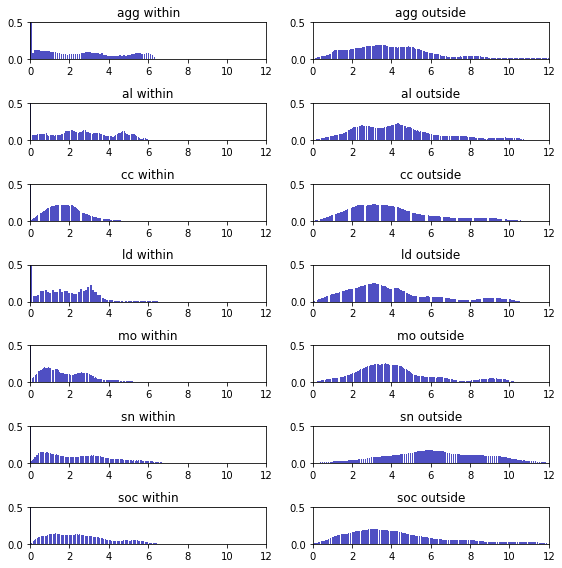

In [ ]:
plt.figure(figsize=(8, 8))
i=1
for calltype in calltypes:
  plt.subplot(len(calltypes), 2, i)
  n, bins, patches = plt.hist(x=self_dists[calltype], density=True,
                              bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
  # np.arange(0,800,25)
  plt.grid(axis='y', alpha=0.75)
  title = calltype+" within"
  plt.title(title)
  plt.xlim(0,12)
  plt.ylim(0, 0.5)
  plt.subplot(len(calltypes), 2, i+1)
  n, bins, patches = plt.hist(x=other_dists[calltype], density=True,
                              bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  title = calltype+" outside"
  plt.title(title)
  plt.xlim(0,12)
  plt.ylim(0, 0.5)
  i=i+2
plt.tight_layout()
plt.savefig(FIGURES+'within_outside_dist.png')

In [ ]:
from scipy import stats

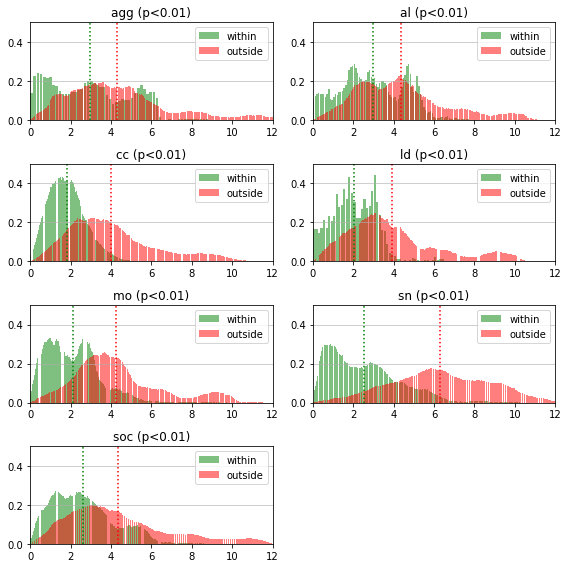

In [ ]:
plt.figure(figsize=(8, 8))
i=1
for calltype in calltypes:
  plt.subplot(4, 2, i)
  n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=True,
                              bins='auto', color='green',
                              alpha=0.5, rwidth=0.85)
  
  plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

  #plt.vlines(x=np.mean(self_dists[calltype])-stats.sem(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')
  #plt.vlines(x=np.mean(self_dists[calltype])+stats.sem(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')


  #plt.hlines(y=0.4,xmin=np.mean(self_dists[calltype])-np.std(self_dists[calltype]),
  #           xmax=np.mean(self_dists[calltype])-np.std(self_dists[calltype]),color='black',linestyles='dotted')

  n, bins, patches = plt.hist(x=other_dists[calltype], label="outside", density=True,
                              bins='auto', color='red',
                              alpha=0.5, rwidth=0.85)
  
  plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  #plt.vlines(x=np.mean(other_dists[calltype])-stats.sem(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  #plt.vlines(x=np.mean(other_dists[calltype])+stats.sem(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  
  s, pval = stats.ttest_ind(self_dists[calltype],other_dists[calltype])

  if pval<0.01:
    pval = "p<0.01"
  else:
    pval = "p="+str(round(pval,2))

  plt.legend()
  plt.grid(axis='y', alpha=0.75)
  plt.title(calltype+" ("+pval+")")
  plt.xlim(0,12)
  plt.ylim(0, 0.5)

  i=i+1

plt.tight_layout()
plt.savefig(FIGURES+'within_oustide_fancy.png')

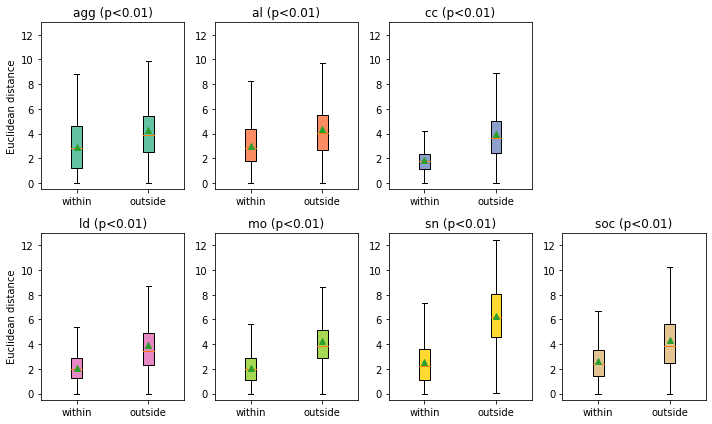

In [ ]:
fig = plt.figure(figsize=(10, 6))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in zip([1,2,3,5,6,7,8],calltypes):

  plt.subplot(2, 4, i)

  data = [self_dists[calltype],
          other_dists[calltype]]

  bp = plt.boxplot(data,
            labels= ['within', 
                     'outside'],
            showmeans= True,
            patch_artist = True,
            showfliers=False)
  
  plt.ylim(-0.5,13)

  for patch in bp['boxes']:
    patch.set_facecolor(color_dict[calltype])
  if i in [1,5]:
    plt.ylabel('Euclidean distance')

  s, pval = stats.ttest_ind(self_dists[calltype],other_dists[calltype])

  if pval<0.01:
    pval = "p<0.01"
  else:
    pval = "p="+str(round(pval,2))

  plt.title(calltype+" ("+pval+")")

plt.tight_layout()
plt.savefig(FIGURES+'with_out_boxplot.png')

## Silhouette Plot

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
specs = df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

In [ ]:
labels = umap_df.call_lable

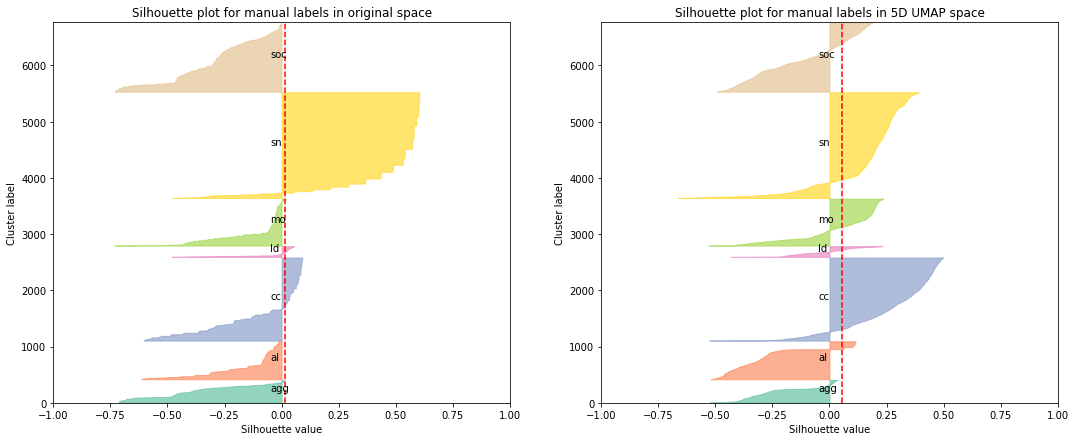

In [ ]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

# Create a subplot with 1 row and 2 columns
#fig, ax1 = plt.figure(figsize= (10, 10))
fig, (ax2, ax1) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.set_xlim([-1, 1])

ax1.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i


  ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot for manual labels in 5D UMAP space")
ax1.set_xlabel("Silhouette value")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


##### ****************************************************
ax2.set_xlim([-1, 1])

ax2.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(data, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(data, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i


  ax2.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
  ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax2.set_title("Silhouette plot for manual labels in original space")
ax2.set_xlabel("Silhouette value")
ax2.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")


#plt.show()
plt.savefig(FIGURES+'SIL_UMAP_original.png')

In [ ]:
# Original % with neg scores
sample_silhouette_values = silhouette_samples(data, cluster_labels)
print(sample_silhouette_values[sample_silhouette_values<=0].shape[0]/sample_silhouette_values.shape[0])

0.4964857185583969


In [ ]:
# UMAP % with neg scores
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
print(sample_silhouette_values[sample_silhouette_values<=0].shape[0]/sample_silhouette_values.shape[0])

0.32899656049050396


Sil scores and % with negative scores as unweighted average per class

In [ ]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

prop_neg_dict_UMAP = {}
sil_UMAP ={}

#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
  neg_vals = ith_cluster_silhouette_values[ith_cluster_silhouette_values<=0]

  print(cluster_label, ": ", neg_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100)

  prop_neg_dict_UMAP[cluster_label] = neg_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100
  sil_UMAP[cluster_label] = np.mean(ith_cluster_silhouette_values)

##### ****************************************************

prop_neg_dict_original = {}
sil_original = {}
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(data, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(data, cluster_labels)


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
  neg_vals = ith_cluster_silhouette_values[ith_cluster_silhouette_values<=0]

  print(cluster_label, ": ", neg_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100)
  prop_neg_dict_original[cluster_label] = neg_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100
  sil_original[cluster_label] = np.mean(ith_cluster_silhouette_values)

agg :  89.72431077694235
al :  66.17429837518463
cc :  8.992562542258282
ld :  70.15706806282722
mo :  32.77511961722488
sn :  10.89845826687932
soc :  52.94117647058824
agg :  77.19298245614034
al :  99.70457902511079
cc :  24.07031778228533
ld :  98.95287958115183
mo :  81.69856459330144
sn :  1.541733120680489
soc :  88.23529411764706


In [ ]:
np.mean(np.asarray([prop_neg_dict_UMAP[x] for x in calltypes]))

47.38042773027213

In [ ]:
np.mean(np.asarray([prop_neg_dict_original[x] for x in calltypes]))

67.34233581090247

In [ ]:
np.mean(np.asarray([sil_original[x] for x in calltypes]))

-0.05454895355560452

In [ ]:
np.mean(np.asarray([sil_UMAP[x] for x in calltypes]))

0.050995840083331516

# Embedding evaluation 2: same vs. different group distances

Evaluate an embedding based on the ratio of distance of a point to all other points of the same label vs. to all other points of other labels

In [ ]:
nn_stats_dict

{'agg': array([[0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 1., ..., 0., 0., 2.],
        [0., 0., 1., ..., 0., 0., 2.],
        ...,
        [3., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 2.],
        [3., 0., 0., ..., 0., 0., 0.]]),
 'al': array([[0., 2., 1., ..., 0., 0., 0.],
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 2.]]),
 'cc': array([[0., 0., 2., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 2., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 2.],
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 0., ..., 0., 0., 3.]]),
 'ld': array([[0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0., ..., 2., 1., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 2., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0.,

In [ ]:
k=3

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
maj_vote_dict = {}

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  n_calls = len(call_indices)
  point_label = calltype
  point_in_majority = 0
  no_majority = 0

  for ind in call_indices:
    nearest_neighbors = indices[ind]
    neighbor_labels = [labels[x] for x in nearest_neighbors]
    most_frequent = Counter(neighbor_labels).most_common(1)

    # is there a majority?
    if most_frequent[0][1] > 1:
      majority_vote = most_frequent[0][0]
      if majority_vote == point_label:
        point_in_majority += 1
    else:
      no_majority += 1

  maj_vote_dict[calltype] = [point_in_majority, no_majority, n_calls]
  # normalize to random probability to have majority vote of same calltype!
  # What is the probability of having >k/2 

  # lead: 0.2%
  # p(4 leads in 8 pulls) = (0.2)^4*(1-0.2)^4 * all possible combinations of arranging 8 items

maj_vote_dict

{'agg': [203, 56, 491],
 'al': [475, 76, 748],
 'cc': [1114, 195, 1936],
 'ld': [19, 38, 208],
 'mo': [636, 144, 995],
 'sn': [1610, 102, 1947],
 'soc': [2508, 291, 3499]}

In [ ]:
calltype = 'sn'
point_label = calltype
call_indices = np.asarray(np.where(labels==calltype))[0]
len(call_indices)
ind = call_indices[10]
nearest_neighbors = indices[ind]
neighbor_labels = [labels[x] for x in nearest_neighbors]
neighbor_labels

['sn', 'sn', 'sn']

In [ ]:
Counter(neighbor_labels).most_common(1)

[('sn', 3)]

In [ ]:
#from collections import Counter

l = ['dog', 'monkey', 'jimbo']
most_frequent = Counter(l).most_common(1)



In [ ]:
most_frequent[0][0]

'dog'

In [ ]:
neighbor_labels

['soc', 'soc', 'soc']

# Embedding evaluation 3: VGG Net similarity of nearest neighbors

Use VGG Net predicted image similarity of spectrograms as ground truth (This will not always be a good idea). 

# Embedding Optimization

Grid search with different parameters to find the best embedding.
Parameters: 
* UMAP parameters (min_dist, spread, metric)
* inputs (stretched, denoised, MFCC etc)
* adding duration as dimension or not

In [ ]:
def make_nn_stats_dict(calltypes, labels, indices):
  nn_stats_dict = {}

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts 
  
  return nn_stats_dict

def get_knn(k,embedding):

  # Scale
  scaler = MinMaxScaler(feature_range=(0,10))
  scaler.fit(embedding)
  embedding = scaler.transform(embedding)
  metric_type = 'euclidean'

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  return indices, distances


def make_statstabs(nn_stats_dict, calltypes, labels):
  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    overall[i] = sum(labels==calltype)

  overall = (overall/np.sum(overall))*100


  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall


  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  x = stats_tab_norm.replace(0,0.0001)
  stats_tab_norm = np.log2(x)

  #stats_tab_norm = np.log2(stats_tab_norm)

  return stats_tab, stats_tab_norm

In [ ]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['cosine']
n_components_list = [2,10]
input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms', 'stretched_denoised_spectrograms', 
              'mfccs','denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']
add_durations = [True, False]
normalize_list = [True, False]

In [ ]:
spec_df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df['index_id'] = spec_df.index
dftype = 'balanced'
spec_df = spec_df[spec_df.nonfocal_yn == 'n']
dftype='focal'

labels = spec_df.call_lable.values
calltypes = sorted(list(set(spec_df.call_lable.values)))

overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  overall[i] = sum(labels==calltype)
overall = (overall/np.sum(overall))*100


f = open("UMAP_optimization_2020-10-26_cosine.txt","w+")
header = ['k',
          'min_dist',
          'spread',
          'metric',
          'n_components',
          'input_var',
          'add_duration',
          'normalize',
          'mean_log_unweighted', 
          'mean_log_weighted',
          'mean_abs_unweighted',
          'mean_abs_weighted']
header = header+calltypes+calltypes
header_str = ";".join(header)
f.write(header_str+"\r\n")
f.close()

In [ ]:
%pwd

'/content/drive/My Drive/meerkat'

In [ ]:
# Example with one:
k=10
MIN_DIST = 0
SPREAD = 1
METRIC = 'euclidean'
N_COMPONENTS = 2
INPUT_VAR = 'denoised_spectrograms'
ADD_DURATION = True
NORMALIZE = False


# Open file
#f = open("UMAP_optimization.txt","w+")
f = open("UMAP_optimization_2020-10-26.txt", "w+")

# Select input data
print('\rPreparing data...',end='')
specs = np.asarray(spec_df[INPUT_VAR])
method = INPUT_VAR

# Flatten and pad with zeros
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

if NORMALIZE:
  data = StandardScaler().fit_transform(pd.DataFrame(data))

# Run UMAP
print('\rRunning UMAP...',end='')
reducer = umap.UMAP(low_memory=True, 
                    n_components = N_COMPONENTS, 
                    metric = METRIC, 
                    min_dist = MIN_DIST,
                    spread = SPREAD)
embedding = reducer.fit_transform(data)

# Get nearest neighbors
print('\rGetting nearest neighbors...',end='')
indices, distances = get_knn(k,embedding)

# count neighbor labels
print('\rCounting neighbor labels...',end='')
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

# Make statstabs
print('\rMaking statstabs...',end='')
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

# Write results to file
print('\rWrite to file...',end='')

#f = open("UMAP_optimization.txt","w+")
f = open("UMAP_optimization_2020-10-26.txt","w+")


params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
params_str = ';'.join([str(x) for x in params])

# Metrics
mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                           np.average(np.diagonal(stats_tab_norm), weights=overall),
                           np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                           np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
all_metrics = np.concatenate((mean_metrics,
                np.diagonal(stats_tab_norm), 
                np.diagonal(stats_tab)))

all_metrics_str = np.char.mod('%f', all_metrics)
all_metrics_str = ";".join(all_metrics_str)

all_results_str = params_str+";"+all_metrics_str
f.write(all_results_str+"\r\n")
f.close()

print('\rDone!',end='')

Done!

Grid search:

In [ ]:
spec_df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df['index_id'] = spec_df.index
dftype = 'balanced'

spec_df = spec_df[spec_df.nonfocal_yn == 'n']
dftype='focal'


labels = spec_df.call_lable.values
calltypes = sorted(list(set(spec_df.call_lable.values)))

In [ ]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['cosine']
n_components_list = [2,10]

input_vars = ['spectrograms',  'stretched_spectrograms', 'denoised_spectrograms', 'denoised_stretched_spectrograms', 
          'mfccs','stretched_mfccs','denoised_mfccs', 'denoised_stretched_mfccs']

normalize_list = [True, False]

In [ ]:
for input_var in input_vars:
  for normalize in normalize_list:
    for min_dist in min_dists:
      for metric in metrics:
        for spread in spreads:
          for n_components in n_components_list:
              print(input_var, normalize, min_dist, metric, spread, n_components)

              # Select input data
              print('\rPreparing data...',end='')
              specs = np.asarray(spec_df[input_var])

              # Flatten and pad with zeros
              maxlen= np.max([spec.shape[1] for spec in specs])
              flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
              data = np.asarray(flattened_specs)

              if normalize:
                data = StandardScaler().fit_transform(pd.DataFrame(data))

              # Run UMAP
              print('\rRunning UMAP...',end='')
              reducer = umap.UMAP(low_memory=True, 
                                  n_components = n_components, 
                                  metric = metric, 
                                  min_dist = min_dist,
                                  spread = spread)
              embedding = reducer.fit_transform(data)

              add_duration = False

              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              #f = open("UMAP_optimization_cosine.txt","a")
              f = open("UMAP_optimization_2020-10-26_cosine.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n')  

              add_duration = True
              embedding_df = pd.DataFrame(embedding)
              embedding_df['duration'] = spec_df.duration_s.values
              embedding = np.asarray(embedding_df)     


              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              #f = open("UMAP_optimization_cosine.txt","a")
              f = open("UMAP_optimization_2020-10-26_cosine.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n') 



spectrograms True 0 cosine 1 2
Done!
Done!
spectrograms True 0 cosine 1 10
Done!
Done!
spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms True 0.1 cosine 1 2
Done!
Done!
spectrograms True 0.1 cosine 1 10
Done!
Done!
spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0 cosine 1 2
Done!
Done!
spectrograms False 0 cosine 1 10
Done!
Done!
spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0.1 cosine 1 2
Done!
Done!
spectrograms False 0.1 cosine 1 10
Done!
Done!
spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0 cosine 1 2
Done!
Done!
stretched_spectrograms True 0 cosine 1 10
Done!
Done!
stretched_spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0.1 cosine 1 2
Done!
Done!
stretched_spectrograms True 0.1 cosine 1 10
Done!
Done!
stretched_spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0 cosine 1 2
Done!
Done!
stretched_spectrograms False 0 cosine 1 10
Done!
Done!
stretched_spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0.1 cosine 1 2
Done!
Done!
stretched_spectrograms False 0.1 cosine 1 10
Done!
Done!
stretched_spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0 cosine 1 2
Done!
Done!
denoised_spectrograms True 0 cosine 1 10
Done!
Done!
denoised_spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0.1 cosine 1 2
Done!
Done!
denoised_spectrograms True 0.1 cosine 1 10
Done!
Done!
denoised_spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0 cosine 1 2
Done!
Done!
denoised_spectrograms False 0 cosine 1 10
Done!
Done!
denoised_spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0.1 cosine 1 2
Done!
Done!
denoised_spectrograms False 0.1 cosine 1 10
Done!
Done!
denoised_spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms True 0 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms False 0 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0 cosine 1 2
Done!
Done!
mfccs True 0 cosine 1 10
Done!
Done!
mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0.1 cosine 1 2
Done!
Done!
mfccs True 0.1 cosine 1 10
Done!
Done!
mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0 cosine 1 2
Done!
Done!
mfccs False 0 cosine 1 10
Done!
Done!
mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0.1 cosine 1 2
Done!
Done!
mfccs False 0.1 cosine 1 10
Done!
Done!
mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0 cosine 1 2
Done!
Done!
stretched_mfccs True 0 cosine 1 10
Done!
Done!
stretched_mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0.1 cosine 1 2
Done!
Done!
stretched_mfccs True 0.1 cosine 1 10
Done!
Done!
stretched_mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0 cosine 1 2
Done!
Done!
stretched_mfccs False 0 cosine 1 10
Done!
Done!
stretched_mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0.1 cosine 1 2
Done!
Done!
stretched_mfccs False 0.1 cosine 1 10
Done!
Done!
stretched_mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0 cosine 1 2
Done!
Done!
denoised_mfccs True 0 cosine 1 10
Done!
Done!
denoised_mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0.1 cosine 1 2
Done!
Done!
denoised_mfccs True 0.1 cosine 1 10
Done!
Done!
denoised_mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0 cosine 1 2
Done!
Done!
denoised_mfccs False 0 cosine 1 10
Done!
Done!
denoised_mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0.1 cosine 1 2
Done!
Done!
denoised_mfccs False 0.1 cosine 1 10
Done!
Done!
denoised_mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0 cosine 1 2
Done!
Done!
denoised_stretched_mfccs True 0 cosine 1 10
Done!
Done!
denoised_stretched_mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 1 2
Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 1 10
Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0 cosine 1 2
Done!
Done!
denoised_stretched_mfccs False 0 cosine 1 10
Done!
Done!
denoised_stretched_mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 1 2
Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 1 10
Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!


## Analyzing grid search results

In [ ]:
k=5
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['euclidean', 'cosine']
n_components_list = [2,10]
input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms', 'stretched_denoised_spectrograms', 
              'mfccs','denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']
add_durations = [True, False]
normalize_list = [True, False]

In [ ]:
import scipy.stats as stats

opti_table_all = pd.read_csv(PROJECT_PATH+'UMAP_optimization.txt', sep=";", header=0)

opti_table_euclid = pd.read_csv(PROJECT_PATH+'UMAP_optimization_2020-10-26.txt', sep=";", header=0)
opti_table_cosine = pd.read_csv(PROJECT_PATH+'UMAP_optimization_2020-10-26_cosine.txt', sep=";", header=0)
opti_table_all = pd.concat([opti_table_euclid, opti_table_cosine])
#opti_table = opti_table_all.loc[opti_table_all['metric']=='euclidean']
#opti_table = opti_table[opti_table.input_var.isin(['spectrograms', 'denoised_spectrograms', 'denoised_stretched_spectrograms', 'stretched_spectrograms'])]
var_of_interest = 'mean_abs_unweighted'

In [ ]:
opti_table = opti_table_all.iloc[:,0:12]

In [ ]:
# use only euclidean
opti_table = opti_table.loc[opti_table_all['metric']=='euclidean']

In [ ]:
opti_table

k  min_dist  ...  mean_abs_unweighted mean_abs_weighted
0    10       0.0  ...            44.877835         54.217053
1    10       0.0  ...            44.418666         53.852227
2    10       0.0  ...            46.232075         55.786787
3    10       0.0  ...            46.089626         55.724032
4    10       0.0  ...            45.482199         54.953906
..   ..       ...  ...                  ...               ...
251  10       0.1  ...            61.982468         72.410648
252  10       0.1  ...            54.868883         65.048602
253  10       0.1  ...            58.777208         70.022432
254  10       0.1  ...            58.333907         68.157619
255  10       0.1  ...            61.910535         72.421116

[512 rows x 12 columns]

In [ ]:
opti_table_all

k  min_dist  spread  ...       mo.1       sn.1      soc.1
0    10       0.0       1  ...  45.765550  88.617757  45.228758
1    10       0.0       1  ...  43.648325  88.654971  44.697712
2    10       0.0       1  ...  48.887560  89.191919  47.434641
3    10       0.0       1  ...  48.528708  89.218501  47.352941
4    10       0.0       5  ...  47.703349  88.437002  47.099673
..   ..       ...     ...  ...        ...        ...        ...
251  10       0.1       1  ...  68.289474  91.786284  59.665033
252  10       0.1       5  ...  62.763158  86.092504  51.960784
253  10       0.1       5  ...  64.904306  92.636895  56.053922
254  10       0.1       5  ...  64.665072  86.507177  57.459150
255  10       0.1       5  ...  67.978469  91.982988  59.591503

[512 rows x 26 columns]

In [ ]:
opti_table['input_var'].value_counts()

denoised_mfccs                     64
denoised_stretched_spectrograms    64
spectrograms                       64
denoised_stretched_mfccs           64
stretched_mfccs                    64
mfccs                              64
denoised_spectrograms              64
stretched_spectrograms             64
Name: input_var, dtype: int64

In [ ]:
opti_table['metric'].value_counts()

euclidean    256
cosine       256
Name: metric, dtype: int64

In [ ]:
opti_table['min_dist'].value_counts()

0.1    256
0.0    256
Name: min_dist, dtype: int64

In [ ]:
opti_table['k'].value_counts()

10    256
Name: k, dtype: int64

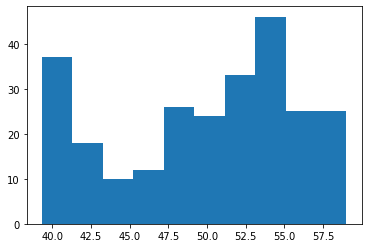

In [ ]:
n, bins, patches = plt.hist(opti_table['mean_abs_unweighted'])

In [ ]:
import scipy.stats as stats

var_of_interest = 'mean_abs_unweighted'
#var_of_interest = 'mean_abs_weighted'
group_var = 'input_var'


#res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[3]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]
#               )
#print(group_var, ":", res.pvalue)

group_var = 'normalize'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'add_duration'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'min_dist'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == min_dists[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  min_dists[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'spread'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == spreads[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  spreads[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'n_components'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]],
                      )
print(group_var, ":", res.pvalue)

normalize : 6.037038115314089e-10
add_duration : 0.004870769489828951
min_dist : 0.9660873638528836
spread : 0.39166160986124776
n_components : 1.0014073595181901e-08


In [ ]:
ll = 40
ul = 70

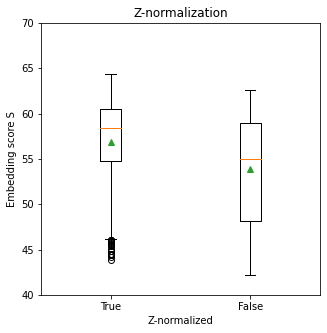

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'normalize'
data = [opti_table[var_of_interest][opti_table[group_var] == normalize_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  normalize_list[1]]]


ax.boxplot(data,
           labels= normalize_list,
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Z-normalized")
plt.title("Z-normalization")
plt.ylabel("Embedding score S")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')


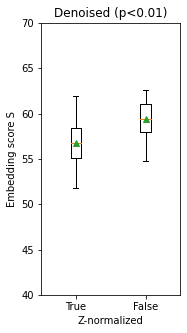

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'normalize'

subset_denoised = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'denoised_spectrograms', 'denoised_stretched_MFCCs', 'denoised_MFCCs'])]
subset_not_denoised = opti_table[opti_table.input_var.isin(['stretched_spectrograms', 'spectrograms', 'stretched_MFCCs', 'MFCCs'])]

var_of_interest = 'mean_abs_unweighted'
data = [subset_denoised[var_of_interest][subset_denoised[group_var] == True],
        subset_denoised[var_of_interest][subset_denoised[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Z-normalized")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Denoised ("+pval+")")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-6.318706425615156, pvalue=4.157410839613772e-09)

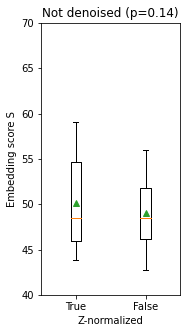

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

data = [subset_not_denoised[var_of_interest][subset_not_denoised[group_var] == True],
        subset_not_denoised[var_of_interest][subset_not_denoised[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Z-normalized")
plt.ylabel("Embedding score S")

s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Not denoised ("+pval+")")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'_2.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=1.892327578712484, pvalue=0.06311871948037019)

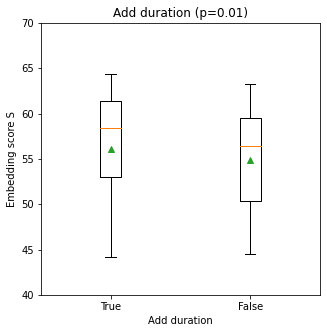

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'
data = [opti_table[var_of_interest][opti_table[group_var] == True],
        opti_table[var_of_interest][opti_table[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Add duration ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

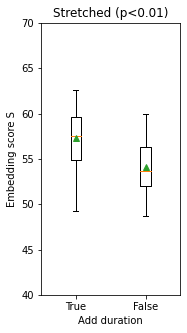

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'

subset_stretched = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'stretched_spectrograms'])]
subset_padded = opti_table[opti_table.input_var.isin(['denoised_spectrograms', 'spectrograms'])]

data = [subset_stretched[var_of_interest][subset_stretched[group_var] == True],
        subset_stretched[var_of_interest][subset_stretched[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Stretched ("+pval+")")



plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'_stretched.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=2.9984341732494557, pvalue=0.0039018195744512543)

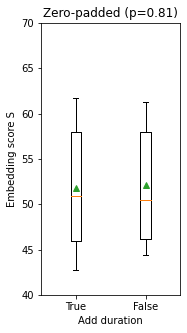

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'

subset_stretched = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'stretched_spectrograms'])]
subset_padded = opti_table[opti_table.input_var.isin(['denoised_spectrograms', 'spectrograms'])]

data = [subset_padded[var_of_interest][subset_padded[group_var] == True],
        subset_padded[var_of_interest][subset_padded[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
plt.title('Zero-padded')

s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Zero-padded ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'_padded.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-0.026523466775960805, pvalue=0.9789250040896431)

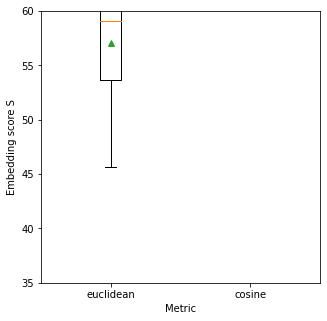

In [ ]:
# Effect of UMAP distance metric
# Need to filter because I tested the angular only on min_dist 0.1, spread 1, n_components 10


fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

dat1=opti_table_all.loc[(opti_table_all['metric'] == 'euclidean') & 
                   (opti_table_all['min_dist'] ==0.1) &
                   (opti_table_all['spread'] ==1) &
                   (opti_table_all['n_components'] ==10)]
dat1 = dat1[var_of_interest]

dat2 = opti_table_all.loc[(opti_table_all['metric'] == 'cosine') & 
                   (opti_table_all['min_dist'] ==0.1) &
                   (opti_table_all['spread'] ==1) &
                   (opti_table_all['n_components'] ==10)]
dat2 = dat2[var_of_interest]         

data = [dat1,dat2]


ax.boxplot(data,
           labels= ['euclidean', 'cosine'],
           showmeans= True)
plt.ylim([35,60])
plt.xlabel("Metric")
plt.ylabel("Embedding score S")



plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

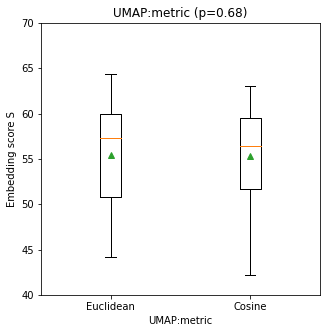

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'metric'
data = [opti_table[var_of_interest][opti_table[group_var] == 'euclidean'],
        opti_table[var_of_interest][opti_table[group_var] ==  'cosine']]


ax.boxplot(data,
           labels= ['Euclidean', 'Cosine'],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("UMAP:metric")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("UMAP:metric ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(dat1,dat2)

Ttest_indResult(statistic=-0.4628033985310598, pvalue=0.6451255959842207)

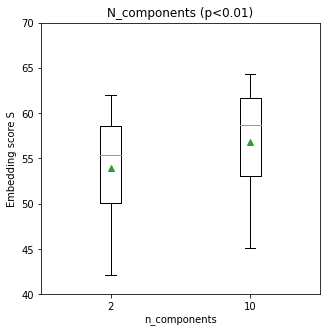

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'n_components'
data = [opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]]]


ax.boxplot(data,
           labels= [n_components_list[0], n_components_list[1]],
           showmeans= True)
plt.ylim([ll,ul])
plt.xlabel("n_components")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("N_components ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-3.9975925543689237, pvalue=8.39211679752964e-05)

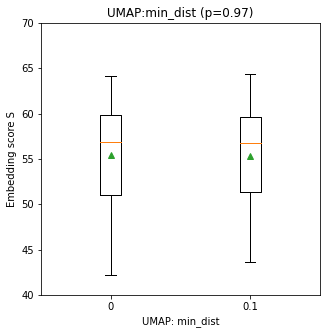

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'min_dist'
data = [opti_table[var_of_interest][opti_table[group_var] == min_dists[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  min_dists[1]]]


ax.boxplot(data,
           labels= min_dists,
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("UMAP: min_dist")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("UMAP:min_dist ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=0.13838440101517765, pvalue=0.8900462712984369)

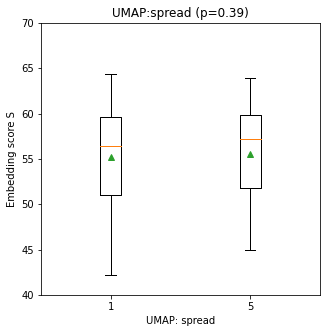

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'spread'
data = [opti_table[var_of_interest][opti_table[group_var] == spreads[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  spreads[1]]]


ax.boxplot(data,
           labels= spreads,
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("UMAP: spread")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("UMAP:spread ("+pval+")")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
s, pval = stats.ttest_ind(data[0],data[1])
pval

0.6061877054552733

In [ ]:
input_vars

['mfccs']

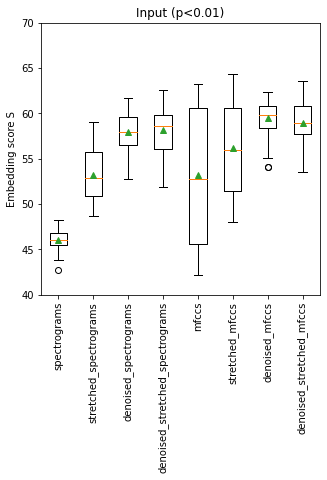

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set
group_var = 'input_var'
data = [opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[3]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]]


ax.boxplot(data,
           labels= input_vars,
           showmeans= True)
plt.ylim([ll,ul])
plt.xlabel("")
plt.ylabel("Embedding score S")
plt.xticks(rotation=90)
plt.title("Input (p<0.01)")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

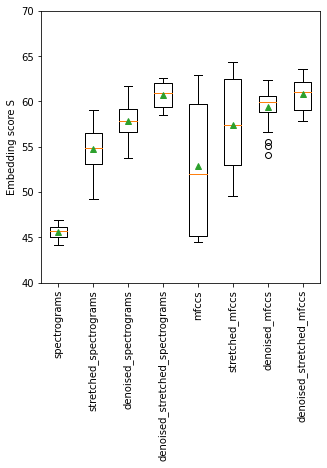

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

opti_table_sub = opti_table[opti_table.add_duration==True]
ax.set
group_var = 'input_var'
data = [opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[0]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[1]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[2]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[3]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[4]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[5]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[6]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[7]]]


ax.boxplot(data,
           labels= input_vars,
           showmeans= True)
plt.ylim([ll,ul])
plt.xlabel("")
plt.ylabel("Embedding score S")
plt.xticks(rotation=90)

plt.show()

In [ ]:
opti_sorted = opti_table.sort_values(by=['mean_abs_unweighted'], ascending=False)
#opti_sorted.loc[opti_sorted['input_var']=='stretched_mfccs',:]

In [ ]:
opti_sorted.iloc[0:40,]

k  min_dist  ...  mean_abs_unweighted mean_abs_weighted
171  10       0.1  ...            64.326699         71.629137
163  10       0.0  ...            64.171100         71.429960
175  10       0.1  ...            63.932175         71.173364
167  10       0.0  ...            63.777893         71.068030
235  10       0.1  ...            63.534537         70.619661
130  10       0.0  ...            63.242753         70.261191
231  10       0.0  ...            63.114899         70.228528
239  10       0.1  ...            63.094785         70.257895
138  10       0.1  ...            63.026309         70.407286
142  10       0.1  ...            62.949828         69.815984
139  10       0.1  ...            62.934570         70.601350
131  10       0.0  ...            62.884653         70.342242
227  10       0.0  ...            62.728419         69.864580
134  10       0.0  ...            62.666793         69.728884
143  10       0.1  ...            62.661344         69.760680
127  10       0.1  ...            62.603959         70.371094
119  10       0.0  ...            62.577332         70.427229
123  10       0.1  ...            62.542984         70.022482
135  10       0.0  ...            62.403232         69.598867
195  10       0.0  ...            62.396532         69.487995
115  10       0.0  ...            62.344199         69.866056
203  10       0.1  ...            62.322797         69.595684
199  10       0.0  ...            62.170120         69.402950
165  10       0.0  ...            62.025249         69.689043
206  10       0.1  ...            61.983595         68.747580
207  10       0.1  ...            61.960930         69.205894
111  10       0.1  ...            61.927616         69.831304
251  10       0.1  ...            61.894282         68.823156
198  10       0.0  ...            61.868517         68.703311
174  10       0.1  ...            61.853125         68.351009
166  10       0.0  ...            61.818602         68.215765
202  10       0.1  ...            61.818050         68.868951
255  10       0.1  ...            61.815820         68.863247
194  10       0.0  ...            61.764546         68.798220
162  10       0.0  ...            61.724995         68.303509
247  10       0.0  ...            61.716030         68.717223
83   10       0.0  ...            61.681276         69.134936
161  10       0.0  ...            61.631188         69.944605
170  10       0.1  ...            61.623707         68.254107
173  10       0.1  ...            61.584185         69.563592

[40 rows x 12 columns]

In [ ]:
opti_table.columns

Index(['k', 'min_dist', 'spread', 'metric', 'n_components', 'input_var',
       'add_duration', 'normalize', 'mean_log_unweighted', 'mean_log_weighted',
       'mean_abs_unweighted', 'mean_abs_weighted'],
      dtype='object')

## How many dimensions?

Evaluate, how many dimensions are best for the embedding.

In [ ]:
embedding_filename = '2020-10-14_embedding_denoised_melspectro_balanced'
embedding_filename = '2020-20-26_embedding_denoised_melspectro_focal_10dims'
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = np.asarray(embedding[:,0:10])

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']

In [ ]:
umap_df = spec_df

In [ ]:
k=5

In [ ]:
dims_tab = np.zeros((9,1))
labels = umap_df.call_lable.values
calltypes = sorted(list(set(labels)))

for n_dims in range(1,10):
  # Get nearest neighbors
  indices, distances = get_knn(k,embedding[:,0:n_dims])
  nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
  stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)
  
  mean_metric = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  print(mean_metric)
  dims_tab[n_dims-1,:] = mean_metric

34.92620506913381
49.43836447692416
59.37589233807086
61.93366574685317
62.047579605527844
62.300672020609106
62.27659145765519
62.01257833116335
62.2062926126217


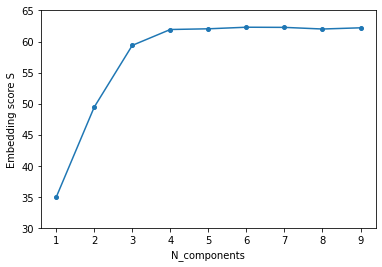

In [ ]:
x = np.arange(1,10,1)
y = dims_tab[:9,0]
plt.plot(x,y, marker='o', markersize=4)
plt.xlabel("N_components")
plt.ylabel("Embedding score S")
plt.ylim(30,65)
#plt.show()
plt.savefig(FIGURES+'n_dims.png')

# Graph from embedding evaluation

Resource: https://en.it1352.com/article/d096c1eadbb84c19b038eb9648153346.html

In [ ]:
stats_tab_norm

agg        al        cc        ld        mo        sn       soc
agg  2.915297 -2.198610 -0.741042 -3.832458 -3.438827 -3.178117  0.938794
al  -2.488117  2.694885 -1.393385 -0.425301  0.231946 -2.628294 -2.344447
cc  -1.134384 -1.599836  1.778445 -1.313229 -2.744026 -3.301376 -0.585595
ld  -4.832458 -0.617946 -1.382770  3.323115  1.733423 -4.162607 -0.495405
mo  -3.207501 -0.031669 -2.275121  1.658848  2.434532 -2.739996 -2.170141
sn  -2.672882 -2.564164 -3.183271 -4.162607 -2.970609  1.691681 -2.994569
soc  0.793644 -2.429695 -0.371912 -0.530738 -2.248615 -2.968097  1.771306

In [ ]:
np.power(2,stats_tab_norm)

agg        al        cc         ld        mo        sn       soc
agg  7.543829  0.217847  0.598307   0.070196  0.092217  0.110482  1.916925
al   0.178239  6.475023  0.380671   0.744684  1.174418  0.161735  0.196902
cc   0.455529  0.329915  3.430562   0.402419  0.149268  0.101435  0.666374
ld   0.035098  0.651598  0.383482  10.008229  3.325157  0.055838  0.709362
mo   0.108254  0.978288  0.206595   3.157643  5.405890  0.149685  0.222189
sn   0.156813  0.169087  0.110088   0.055838  0.127573  3.230328  0.125471
soc  1.733448  0.185605  0.772758   0.692200  0.210426  0.127795  3.413629

In [ ]:
import graphviz
import networkx as nx
import string

!wget https://anaconda.org/anaconda/pygraphviz/1.3/download/linux-64/pygraphviz-1.3-py36h14c3975_1.tar.bz2
!tar xvjf pygraphviz-1.3-py36h14c3975_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
import pygraphviz

In [ ]:
sim_mat = np.asarray(stats_tab_norm).copy()
#sim_mat = np.asarray(np.power(2,stats_tab_norm)).copy()
for i in range(sim_mat.shape[0]):
  for j in range(i,sim_mat.shape[0]):
    if i!=j:
      #sim_mat[i,j] = gmean((sim_mat[i,j], sim_mat[j,i]))
      sim_mat[i,j] = np.mean((sim_mat[i,j], sim_mat[j,i]))
      sim_mat[j,i] = sim_mat[i,j]
    else:
      sim_mat[i,j] = 0

In [ ]:
pd.DataFrame(sim_mat)

0         1         2         3         4         5         6
0  0.000000  0.197050  0.522060  0.049636  0.099914  0.131625  1.822879
1  0.197050  0.000000  0.354385  0.696588  1.071876  0.165370  0.191170
2  0.522060  0.354385  0.000000  0.392836  0.175608  0.105673  0.717597
3  0.049636  0.696588  0.392836  0.000000  3.240318  0.055838  0.700729
4  0.099914  1.071876  0.175608  3.240318  0.000000  0.138187  0.216228
5  0.131625  0.165370  0.105673  0.055838  0.138187  0.000000  0.126628
6  1.822879  0.191170  0.717597  0.700729  0.216228  0.126628  0.000000

In [ ]:
#sim_mat = np.log2(sim_mat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log2



In [ ]:
for i in range(sim_mat.shape[0]):
  sim_mat[i,i] = 0

In [ ]:
pd.DataFrame(sim_mat)

0         1         2         3         4         5         6
0  0.000000 -2.343363 -0.937713 -4.332458 -3.323164 -2.925500  0.866219
1 -2.343363  0.000000 -1.496610 -0.521623  0.100139 -2.596229 -2.387071
2 -0.937713 -1.496610  0.000000 -1.347999 -2.509574 -3.242324 -0.478753
3 -4.332458 -0.521623 -1.347999  0.000000  1.696135 -4.162607 -0.513072
4 -3.323164  0.100139 -2.509574  1.696135  0.000000 -2.855303 -2.209378
5 -2.925500 -2.596229 -3.242324 -4.162607 -2.855303  0.000000 -2.981333
6  0.866219 -2.387071 -0.478753 -0.513072 -2.209378 -2.981333  0.000000

In [ ]:
dist_mat = sim_mat*(-1)
dist_mat = np.interp(dist_mat, (dist_mat.min(), dist_mat.max()), (1, 10))

In [ ]:
for i in range(dist_mat.shape[0]):
  dist_mat[i,i] = 0

In [ ]:
pd.DataFrame(dist_mat, columns=calltypes, index=calltypes)

agg        al        cc         ld        mo        sn       soc
agg   0.000000  7.030509  4.932034  10.000000  8.493239  7.899572  2.238970
al    7.030509  0.000000  5.766404   4.310859  3.382640  7.408008  7.095759
cc    4.932034  5.766404  0.000000   5.544544  7.278642  8.372554  4.246860
ld   10.000000  4.310859  5.544544   0.000000  1.000000  9.746431  4.298093
mo    8.493239  3.382640  7.278642   1.000000  0.000000  7.794776  6.830484
sn    7.899572  7.408008  8.372554   9.746431  7.794776  0.000000  7.982925
soc   2.238970  7.095759  4.246860   4.298093  6.830484  7.982925  0.000000

In [ ]:
dt = [('len', float)]
A = dist_mat

A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),calltypes))) 

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(color="#bec1d4", style="filled", shape='circle', fontsize='20')
G.edge_attr.update(color="blue", width="2.0")

G.draw(FIGURES+'simgraph.png', format='png', prog='neato')

# Make interactive plot df

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
spec_df = df[df['nonfocal_yn']=='n']
spec_df.head(3)

Name        Start  Duration  ... certain_yn index_id nonfocal_yn
1598  ALARM  1:10:56.215  0:00.178  ...          y     1598           n
1599  ALARM  1:12:04.643  0:00.317  ...          y     1599           n
1600  ALARM  1:12:15.132  0:00.192  ...          y     1600           n

[3 rows x 35 columns]

In [ ]:
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
embedding = pd.read_pickle(DATA+df_name)

In [ ]:
embedding.head(3)

UMAP0     UMAP1     UMAP2  ...     UMAP8     UMAP9  UMAPindex_id
0  5.299764  6.417554  4.202350  ...  3.845777  2.846862          1598
1  6.663779  7.219666  3.152430  ...  4.023995  2.729822          1599
2  6.665429  6.820063  4.278993  ...  4.242816  2.590861          1600

[3 rows x 11 columns]

In [ ]:
embedding.columns = ['UMAP'+str(col) for col in embedding.columns]
embedding.columns

Index(['UMAP0', 'UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6', 'UMAP7',
       'UMAP8', 'UMAP9', 'UMAPindex_id'],
      dtype='object')

In [ ]:
for col in embedding.columns:
  spec_df[col] = embedding[col].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(3)

Name        Start  Duration  ...     UMAP8     UMAP9 UMAPindex_id
1598  ALARM  1:10:56.215  0:00.178  ...  3.845777  2.846862         1598
1599  ALARM  1:12:04.643  0:00.317  ...  4.023995  2.729822         1599
1600  ALARM  1:12:15.132  0:00.192  ...  4.242816  2.590861         1600

[3 rows x 46 columns]

In [ ]:
# Add metadata

In [ ]:
sorted(list(set(spec_df['indv'])))
meerkat_info = pd.read_csv(PROJECT_PATH+'Meerkat_info.csv', sep=";")

meerkat_names = meerkat_info['Code']

labelsep = re.compile('[\+\s]') # Match ? * ! %
meerkat_dyemarks = [labelsep.sub('', i) for i in list(meerkat_info['Dye mark'])]
meerkat_info['Dye mark'] = meerkat_dyemarks


meerkat_dict = meerkat_info.drop(columns=['Code', 'Name']).T
meerkat_dict.columns = meerkat_names
meerkat_dict = meerkat_dict.to_dict()

for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    if ind in meerkat_dyemarks:
      ind_row = meerkat_info[meerkat_info['Dye mark']== ind]
      ind_code = meerkat_info[meerkat_info['Dye mark'] == ind].Code.values[0]
      if(ind_code in meerkat_dict.keys()):
        meerkat_dict[ind] = meerkat_dict[ind_code]
        print(ind, "is actually ", ind_code)
    else:
      print(ind, "not in dyemarks")

HMB is actually  VCVM001
HRT not in dyemarks
HTB is actually  VHMF001
LT is actually  VHMF031
PET not in dyemarks
RT is actually  VHMF030
VHMM002 not in dyemarks
VHMM003 not in dyemarks
VLF206 not in dyemarks


In [ ]:
meerkat_dict['PET'] = meerkat_dict['VCVM001']
meerkat_dict['VLF206'] = {'DOB': '21.08.2013', 
                          'Dye mark': 'RCRSTBL', 
                          'Sex': 'F', 
                          'Status': 'Adult'
                          }
meerkat_dict['VHMM002'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HRT', 
                          'Sex': 'M', 
                          'Status': 'Dominant'
                          }

meerkat_dict['VHMM003'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HLT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }
for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    meerkat_dict[ind] = {'DOB': 'NA', 
                         'Dye mark': 'NA', 
                         'Sex': 'NA', 
                         'Status':'NA'}

In [ ]:
sex = [meerkat_dict[ind]['Sex'] for ind in spec_df['indv']]
spec_df['Sex'] = sex
status = [meerkat_dict[ind]['Status'] for ind in spec_df['indv']]
spec_df['status'] = status

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
filename = [os.path.basename(wav_path) for wav_path in spec_df['original_wav']]
spec_df['filename'] = filename

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(5)

Name  ...                                           filename
1598  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1601  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1602  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...

[5 rows x 49 columns]

In [ ]:
filename = [x[:-4] for x in filename]

In [ ]:
filename_1 = [x[0:30] for x in filename]
filename_2 = [x[30:60] if len(x)>60 else x[30:] for x in filename]
filename_3 = [x[60:] if len(x)>60 else '' for x in filename]

In [ ]:
spec_df['fn_1'] = filename_1
spec_df['fn_2'] = filename_2
spec_df['fn_3'] = filename_3

In [ ]:
plot_df = spec_df[['Name', 'call_lable', 'indv', 'raw_audio', 
                   'denoised_spectrograms','duration_s', 'samplerate_hz', 
                  'UMAP0', 'UMAP1', 'UMAP2', 'index_id', 'Sex', 'status', 'Start', 'fn_1',
                   'fn_2', 'fn_3']]

In [ ]:
plot_df = plot_df.drop(columns=['denoised_spectrograms'])

In [ ]:
plot_df.head(3)

Name call_lable indv  ...                          fn_2  fn_3  HDBSCAN
1598  ALARM         al  HMB  ...  08_23-06_44_59)_ASWMUX221163             -1
1599  ALARM         al  HMB  ...  08_23-06_44_59)_ASWMUX221163             -1
1600  ALARM         al  HMB  ...  08_23-06_44_59)_ASWMUX221163              5

[3 rows x 17 columns]

In [ ]:
os.system('pip install hdbscan')
import hdbscan

In [ ]:
cluster_df = np.asarray(embedding.iloc[:,0:10])
cluster_df.shape

(6687, 10)

In [ ]:
# Cannot set the number of desired clusters in HDBSCAN, thus select min_samples
# so that I hopefully get a similar number of clusters as in original dataset.

# https://hdbscan.readthedocs.io/en/0.8.6/api.html
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=66, #20, # the smallest size we would expect a cluster to be (10 % of dataset size))
    #min_samples=10, # 15, # larger values = more conservative clustering # 10
    cluster_selection_method='leaf'
)
HDBSCAN.fit(cluster_df);

print("Total: ", len(HDBSCAN.labels_))
print("Number of classes: ",np.max(HDBSCAN.labels_)+1)
print("Unassigned: ",sum(HDBSCAN.labels_==-1), "(", sum(HDBSCAN.labels_==-1)/len(HDBSCAN.labels_), ")")

Total:  6687
Number of classes:  13
Unassigned:  3167 ( 0.4736055032151937 )


In [ ]:
#plot_df['HDBSCAN'] = HDBSCAN.labels_

plot_df.to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta')

In [ ]:
plot_df.iloc[:3000,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
plot_df.iloc[3000:,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

In [ ]:
p1 = pd.read_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
p2 = pd.read_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

res = pd.concat([p1,p2])
res.shape

(6687, 17)

# Nearest Neighbor Visualization

In [ ]:
import random
import scipy

In [ ]:
os.listdir(DATA)

In [ ]:
# choose dataset
df = pd.read_pickle(DATA+'df_denoised_balanced')
spec_df = df[df['nonfocal_yn']=='n']

# choose embdding
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
embedding = pd.read_pickle(DATA+df_name)
embedding = embedding.iloc[:,0:10]

In [ ]:
knn=5
n_examples=3
# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=knn+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
calltypes = sorted(list(set(spec_df['call_lable'])))
labels = spec_df.call_lable.values
names = spec_df.Name.values

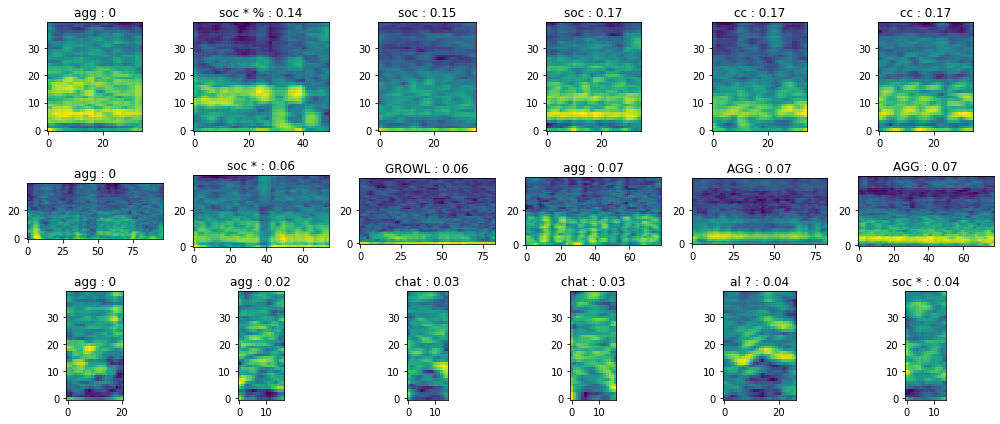

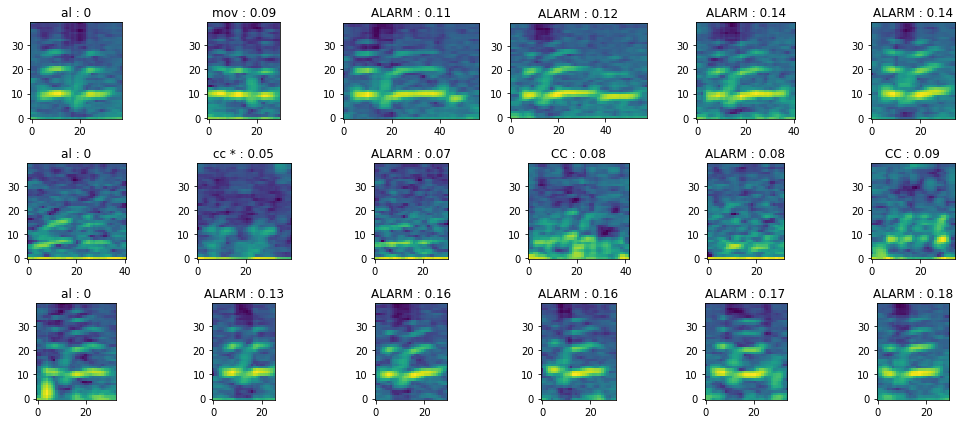

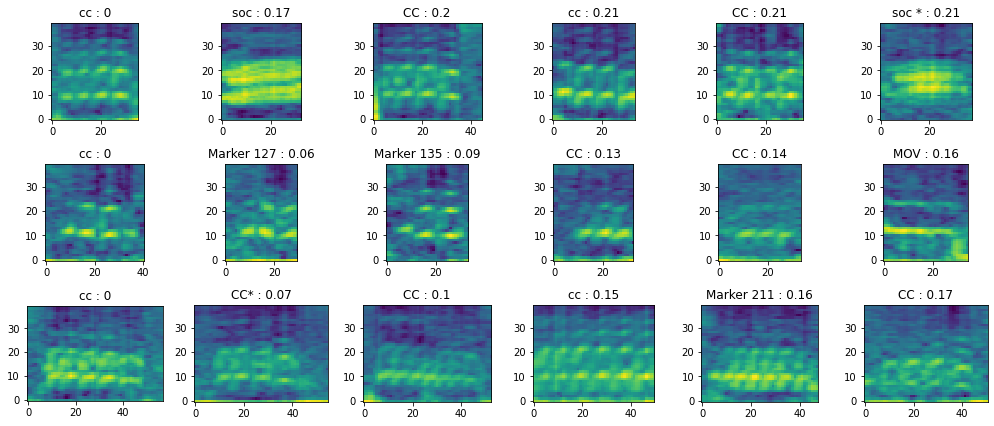

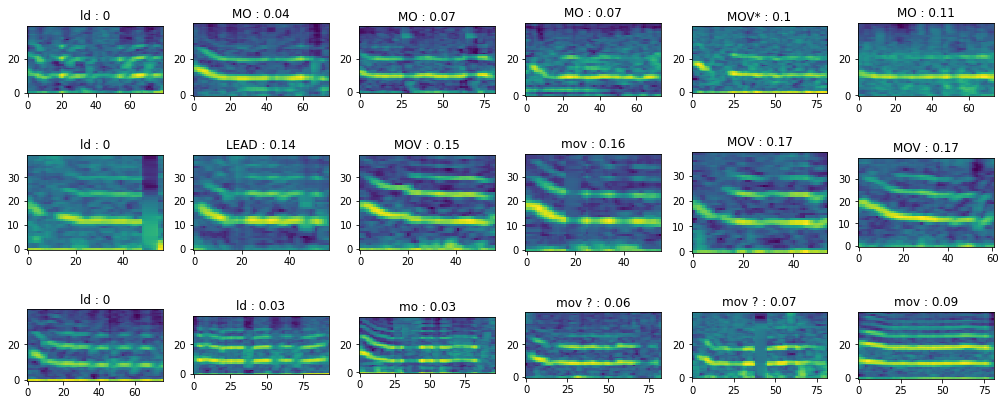

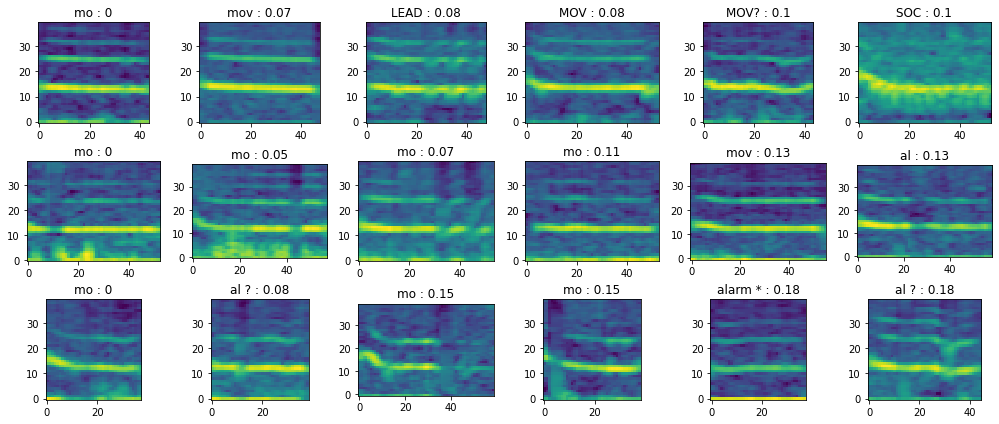

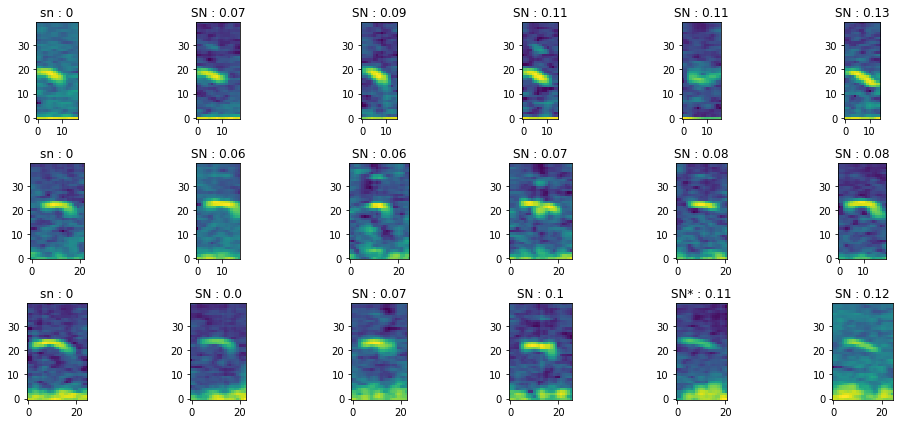

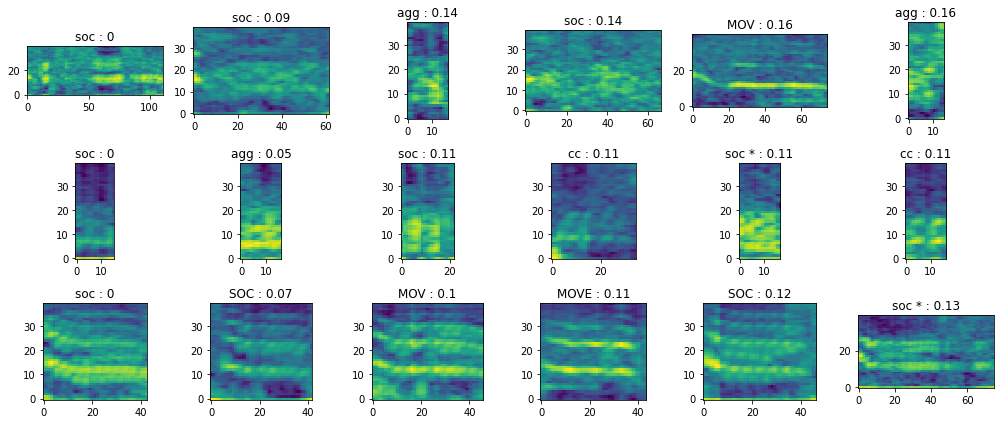

In [ ]:
# make plots

for calltype in calltypes:

  fig = plt.figure(figsize=(14,6))
  fig_name = 'NN_Viz_'+calltype
  k=1
  call_indices = np.asarray(np.where(labels==calltype))[0]

  # randomly choose 3
  example_indices = random.sample(list(call_indices), n_examples)

  for i,ind in enumerate(example_indices):
    img_of_interest = spec_df.iloc[ind,:].denoised_spectrograms
    embedding_of_interest = embedding.iloc[ind,:]
    plt.subplot(n_examples, knn+1, k)
    #librosa.display.specshow(np.transpose(spec))
    plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
    plt.title(calltype+' : 0')
    k=k+1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = names[neighbor]
      neighbor_embedding = embedding.iloc[neighbor,:]
      dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
      neighbor_img = spec_df.iloc[neighbor,:].denoised_spectrograms
      plt.subplot(n_examples, knn+1, k)
      #librosa.display.specshow(np.transpose(spec))
      plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
      plt.title(neighbor_label+' : '+str(round(dist_to_original, 2)))
      k=k+1
        
  plt.tight_layout() 
  plt.savefig(FIGURES+fig_name)

Files for Frants 1

In [ ]:
# Extract calls for Frants!

 Cexample_calls = spec_df.sample(frac=0.003, replace=False, random_state=1)
example_calls_min.shape
example_calls_min.to_pickle(DATA+'example_calls')
for i in range(example_calls_min.shape[0]):
  y = example_calls_min.iloc[i].raw_audio
  sr = example_calls_min.iloc[i].samplerate_hz
  filename = str(example_calls_min.iloc[i].index_id)+'_'+example_calls_min.iloc[i].call_lable+'.wav'

  librosa.output.write_wav(DATA+'frants/'+filename, y, sr, norm=False)

i=4
str(example_calls_min.iloc[i].index_id)+'_'+example_calls_min.iloc[i].call_lable

# Files for Frants 2

In [ ]:
files = os.listdir(DATA+'frants/')

In [ ]:
os.chdir(PROJECT_PATH)
MEERKAT_CHANNEL = json.load(open("meerkat_channel.json"))

In [ ]:
files = os.listdir(DATA+'frants/')
fileIDs = [int(x.split('_')[0]) for x in files]

In [ ]:
def get_audio(wav_loc, start_s, duration_s):
  # SOUNDFOCs are stereo
  if "SOUNDFOC" in wav_loc:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
  else:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

  if np.issubdtype(type(data[0]), np.integer):
    data = int16_to_float32(data)
  return data

In [ ]:
for fileID, filename in zip(fileIDs, files):
  sr = df.loc[df['index_id']==fileID,'samplerate_hz'].values[0]
  dur = df.loc[df['index_id']==fileID,'duration_s'].values[0]
  offset = df.loc[df['index_id']==fileID,'start_s'].values[0]
  wav_loc = df.loc[df['index_id']==fileID,'original_wav'].values[0]

  # add padding
  dur = dur+0.2
  offset = offset-0.1

  y = get_audio(wav_loc, offset, dur)
  librosa.output.write_wav(DATA+'frants_padded/padded_'+filename, y, sr, norm=False)


In [ ]:
fileID

15931

In [ ]:

sr = spec_df.loc[spec_df['index_id']==fileID,'samplerate_hz'].values[0]
dur = spec_df.loc[spec_df['index_id']==fileID,'duration_s'].values[0]
offset = spec_df.loc[spec_df['index_id']==fileID,'start_s'].values[0]
wav_loc = spec_df.loc[spec_df['index_id']==fileID,'original_wav'].values[0]

# add padding
dur = dur+0.2
offset = offset-0.1

y = get_audio(wav_loc, offset, dur)
librosa.output.write_wav(DATA+'frants/padded_'+filename, y, sr, norm=False)


8019


In [ ]:
spec_df.head(3)

Name  ...                                           filename
1598  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...

[3 rows x 49 columns]

# Example plots preprocessing

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']
spec_df.reset_index(inplace=True)

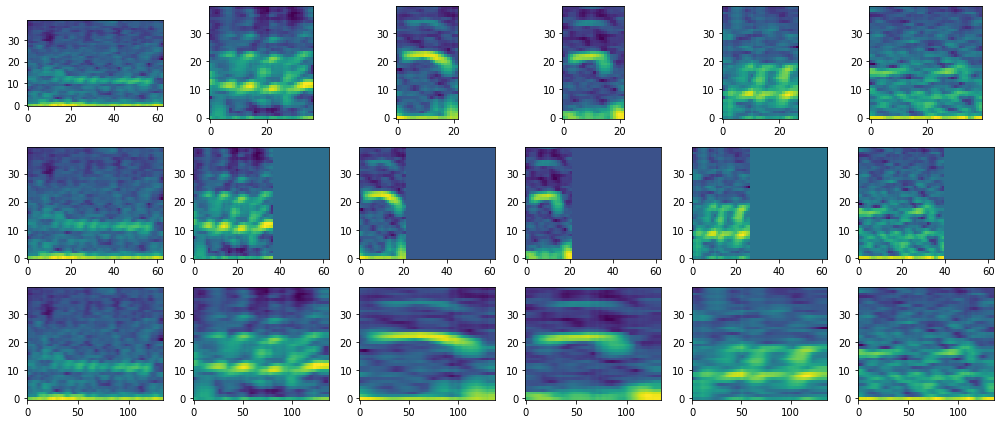

In [ ]:
# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(14,6))
fig_name = 'preprocessing_examples'
k=1

  # randomly choose 4

examples = spec_df.sample(n=6, random_state=1234)
examples.reset_index(inplace=True)

# original 
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_spectrograms
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

stretched = examples.apply(lambda row: generate_stretched_mel_spectrogram_NEW(row['raw_audio'],
                                                                        row['samplerate_hz'], 
                                                                        row['duration_s'],
                                                                        N_MELS,
                                                                        WINDOW,
                                                                        FFT_WIN,
                                                                        FFT_HOP),
                           axis=1)

examples['stretched_new'] = stretched
examples['denoised_stretched_new'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in examples['stretched_new']]



# zero-padded
specs = examples.denoised_spectrograms
maxlen= np.max([spec.shape[1] for spec in specs])
padded_specs = [pad_spectro(spec, maxlen) for spec in specs]

for i in range(examples.shape[0]):
  spec = padded_specs[i]
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1


# stretched
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_stretched_new
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1

plt.tight_layout() 
plt.savefig(FIGURES+fig_name)

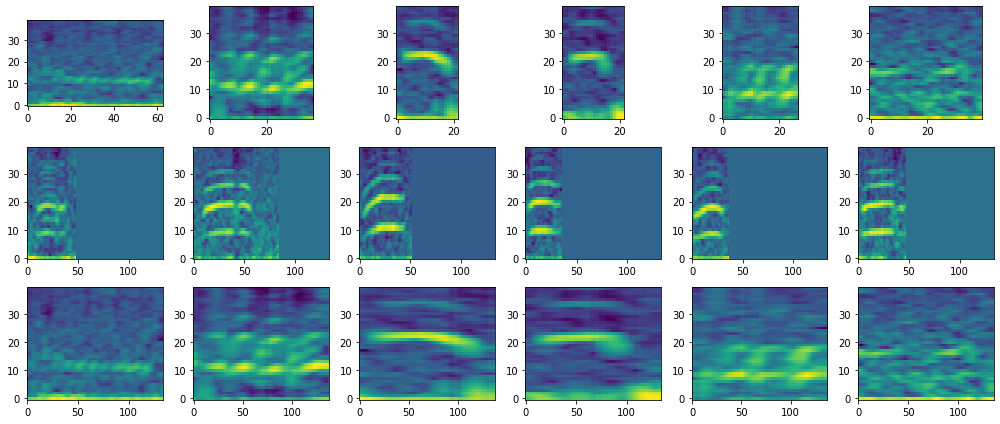

In [ ]:
# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(14,6))
fig_name = 'preprocessing_examples'
k=1

  # randomly choose 4

examples = spec_df.sample(n=6, random_state=1234)
examples.reset_index(inplace=True)

# original 
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_spectrograms
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

stretched = examples.apply(lambda row: generate_stretched_mel_spectrogram_NEW(row['raw_audio'],
                                                                        row['samplerate_hz'], 
                                                                        row['duration_s'],
                                                                        N_MELS,
                                                                        WINDOW,
                                                                        FFT_WIN,
                                                                        FFT_HOP),
                           axis=1)

examples['stretched_new'] = stretched
examples['denoised_stretched_new'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in examples['stretched_new']]



# zero-padded
specs = spec_df.denoised_spectrograms
maxlen= np.max([spec.shape[1] for spec in specs])
padded_specs = [pad_spectro(spec, maxlen) for spec in specs]

for i in range(examples.shape[0]):
  spec = padded_specs[i]
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1


# stretched
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_stretched_new
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1

plt.tight_layout() 
plt.savefig(FIGURES+fig_name)

In [ ]:
@jit(nopython=True)
def preprocess_spec_numba(spec):
    
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec > 3, 3, spec)
    spec = np.where(spec < 0, 0, spec)
    
    return spec

array([[24.188335  , 22.856678  , 18.059265  , ..., 21.389076  ,
        22.148209  , 21.343346  ],
       [12.464241  , 12.01741   ,  9.468864  , ...,  8.198223  ,
         9.503407  ,  8.861595  ],
       [15.790695  , 14.545803  ,  9.023121  , ...,  1.2061462 ,
         5.789692  ,  7.8790054 ],
       ...,
       [-3.3597183 , -3.8820915 , -7.013031  , ..., -0.2532959 ,
        -0.9896965 , -3.693325  ],
       [ 1.0191193 , -0.09102631, -4.9922066 , ..., -1.5644913 ,
        -2.5253372 , -5.223995  ],
       [ 0.58903885, -0.4320488 , -4.494301  , ..., -5.325241  ,
        -5.3667793 , -6.1148605 ]], dtype=float32)

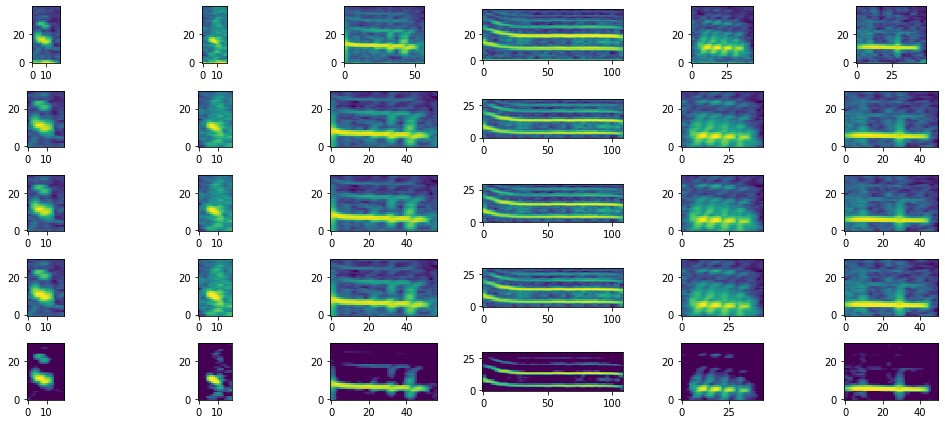

In [ ]:
N_MELS = 40
# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(14,6))
fig_name = 'preprocessing_examples_mara.png'
k=1

# randomly choose 4
examples = spec_df.sample(n=6, random_state=2222)
examples.reset_index(inplace=True)
ori_specs = examples.spectrograms

# original
for i in range(examples.shape[0]):
  spec = ori_specs[i]
  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# cut
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]

  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# z-score
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
  spec = calc_zscore(spec)
  
  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# floor
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
  spec = calc_zscore(spec)
  spec = np.where(spec > 3, 3, spec)

  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# ceiling
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
  spec = calc_zscore(spec)
  spec = np.where(spec > 3, 3, spec)
  spec = np.where(spec < 0, 0, spec)
  
  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

plt.tight_layout() 
plt.savefig(FIGURES+fig_name)

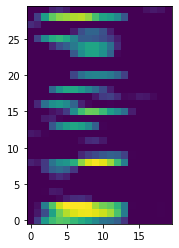

In [ ]:
spec = ori_specs[0]
spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
spec = calc_zscore(spec)
spec = np.where(spec > 3, 3, spec)
spec = np.where(spec < 0, 0, spec)
shuffled = np.copy(spec)
np.random.shuffle(shuffled)
plt.imshow(shuffled, interpolation='nearest', origin='lower', aspect='equal') 